In [1]:
use_dolfinx = False

### colab

In [2]:
import os
colab = os.getcwd() == "/content"
if colab:
    from google.colab import drive
    drive.mount('/content/drive')

In [3]:
# drive.flush_and_unmount()  # Smonta Google Drive
# drive.mount('/content/drive', force_remount=True)  # Rimonta


### import

In [4]:
if colab:
    if use_dolfinx:
        try:
            import dolfinx
        except ImportError:
            !wget "https://fem-on-colab.github.io/releases/fenicsx-install-release-real.sh" -O "/tmp/fenicsx-install.sh" && bash "/tmp/fenicsx-install.sh"
            import dolfinx

In [5]:
if colab:
    if use_dolfinx:
        try:
            import gmsh
        except ImportError:
            !wget "https://fem-on-colab.github.io/releases/gmsh-install.sh" -O "/tmp/gmsh-install.sh" && bash "/tmp/gmsh-install.sh"
            import gmsh

In [6]:
# !mpirun --allow-run-as-root --map-by slot:OVERSUBSCRIBE -np 4 python3 ns_dolfinx.py


In [7]:
from __future__ import print_function


In [8]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys
import copy
import tqdm.autonotebook
if colab:
    if use_dolfinx:
        import gmsh
        from mpi4py import MPI
        from petsc4py import PETSc

        from basix.ufl import element

        from dolfinx.fem import (
            Constant,
            Function,
            functionspace,
            assemble_scalar,
            dirichletbc,
            form,
            locate_dofs_topological,
            set_bc,
        )
        from dolfinx.fem.petsc import (
            apply_lifting,
            assemble_matrix,
            assemble_vector,
            create_vector,
            create_matrix,
            set_bc,
        )
        from dolfinx.geometry import bb_tree, compute_collisions_points, compute_colliding_cells
        from dolfinx.io import VTXWriter, gmshio
        from ufl import (
            FacetNormal,
            Measure,
            TestFunction,
            TrialFunction,
            as_vector,
            div,
            dot,
            dx,
            inner,
            lhs,
            grad,
            nabla_grad,
            rhs,
        )

        gmsh.initialize()

/tmp/ipykernel_1121365/4108979899.py:7: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  import tqdm.autonotebook


In [9]:
from IPython.display import clear_output as clc

plt.style.use("default")


In [10]:
if colab:
    if use_dolfinx:
        import ufl
        from basix.ufl import element, mixed_element
        from dolfinx import fem, la
        from dolfinx.fem import (Constant, Function, dirichletbc,
                                extract_function_spaces, form, functionspace,
                                locate_dofs_topological)
        from dolfinx.fem.petsc import assemble_matrix_block, assemble_vector_block
        from dolfinx.io import XDMFFile
        from dolfinx.mesh import CellType, create_rectangle, locate_entities_boundary
        from ufl import div, dx, grad, inner
        from ufl import CellDiameter, sqrt, FacetArea

In [11]:
from scipy.interpolate import RBFInterpolator

In [12]:
plt.style.use("default")
%config InlineBackend.figure_format = 'retina'

In [13]:
def add_zoom(zoom = 1.5, dpi = 100):
    plt.gcf().set_figheight(plt.gcf().get_figheight() * zoom)
    plt.gcf().set_figwidth(plt.gcf().get_figwidth() * zoom)
    plt.gcf().dpi = dpi

In [14]:
def scatter_array(arr, label = "label", leg = False, zoom = 1, dpi = 100, s = 1, c = None):
    if not c==None:
        plt.scatter(arr[:, 0], arr[:, 1], label = label, s = s, c = c)
    else:
        plt.scatter(arr[:, 0], arr[:, 1], label = label, s = s)
    # plt.scatter(new_control_points_coords[:, 0], new_control_points_coords[:, 1], c = "b", label = "new control pts")

    add_zoom(zoom, dpi = dpi)
    plt.gca().set_aspect("equal")
    plt.gca().set_adjustable("box")

    if leg:
        plt.gca().legend(loc = "upper right")
    # plt.show()

In [15]:
if colab:
    os.chdir("/content/drive/MyDrive/mySHRED/my_SHRED-ROM")

# Parameters

In [16]:
L = 10
H = 4
# N_points = 121  # numero di punti per la discretizzazione dell'airfoil
chord = 1

# Airfoil parameters
chord = 1  # Adjust as needed
Aoa = 20
# N_points = 121
# c_x, c_y = 0.2 * L + 0.5 * chord, H / 2
x_le, y_le = 0.3 * L, 0.5 * H

if colab:
    if use_dolfinx:
        mesh_comm = MPI.COMM_WORLD
        model_rank = 0
        gdim = 2

# Physical and discretization parameters
t = 0
T = 10 # Final time
dt = 0.05  # Time step size
timesteps = int(T / dt)
mu_ = 0.01
rho_ = 1
U_max = 1.5
Re = (U_max * 2 / 3) * chord * rho_ / mu_
print(f"Re: {Re:.2f}")

save_numpy_unsteady = True
save_to_np_every_steps = 1
# save_to_torch_every_steps = 1
save_to_np_every_steps = 1

Re: 100.00


# Mesh generation

In [17]:
# # Mesh parameters
# # res_min = 0.001 # minima grandezza elementi vicino bordo ostacolo
# res_min = 0.01
# LcMin = res_min
# LcMax = 0.05 * H # massima grandezza elementi vicino bordi della mesh
# # LcMax = 0.1 * H
# DistMin = res_min * 3 # distanza dall'ostacolo in cui inizia il grading
# DistMax = H # distanza dall'ostacolo in cui finisce il grading

# # altre modifiche in generating the mesh
# # res_min_wake = 0.005
# res_min_wake = 0.05
# LcMax_wake = 0.05 * H
# DistMin_wake = res_min_wake * 3
# DistMax_wake = H

# Fine mesh
# generate_fine_mesh = True
# write_fine_mesh = False
# save_fine_mesh_numpy = True

# lref = f"cl{chord}_Aoa{Aoa}"
# name = f"{obstacle_type}_{lref}_{L}x{H}_resmin{res_min}_Re{Re}"
# name_unsteady = f"{obstacle_type}_{lref}_{L}x{H}_resmin{res_min}_Re{Re}_dt{dt}"
# name_mesh = f"{obstacle_type}_{lref}_{L}x{H}_resmin{res_min}"
# write_mesh = False
# save_mesh_numpy = True
# write_stokes = False
# write_ns = False
# write_ns_unsteady = False
# save_numpy = False

In [18]:
# airfoil_coords = generate_airfoil(0, 0.4, 0.12, N_points) # NACA 0012
# # mesh = generate_airfoil_mesh(base_pts, L, H, ref = 128)

# ntrajectories = 1
# nparams = 2 + 11 # physical + airfoil

In [19]:
# x_airfoil, y_airfoil = (airfoil_coords[:, 0] + x_le).tolist(), (airfoil_coords[:, 1] + y_le).tolist()

In [20]:
# # if mesh_comm.rank == model_rank:
#     # Create rectangle domain
# rectangle = gmsh.model.occ.addRectangle(0, 0, 0, L, H, tag=1)

In [21]:
# points = []
# for i in range(len(x_airfoil)):
#     point = gmsh.model.occ.addPoint(x_airfoil[i], y_airfoil[i], 0)
#     points.append(point)
# points.append(points[0])
# spline = gmsh.model.occ.addSpline(points)
# # line_last_first = gmsh.model.occ.addLine(points[-1], points[0])
# # airfoil_curve = gmsh.model.occ.addCurveLoop([spline, line_last_first])
# airfoil_curve = gmsh.model.occ.addCurveLoop([spline])
# obstacle = gmsh.model.occ.addPlaneSurface([airfoil_curve])

In [22]:
# p1 = gmsh.model.occ.addPoint(x_le + chord + 0.01, y_le, 0)
# p2 = gmsh.model.occ.addPoint(L, H / 2, 0)
# horizontal_line = gmsh.model.occ.addLine(p1, p2)
# gmsh.model.occ.synchronize()

In [23]:
# fluid = gmsh.model.occ.cut([(gdim, rectangle)], [(gdim, obstacle)])
# gmsh.model.occ.synchronize()

In [24]:
# fluid_marker = 1
# # if mesh_comm.rank == model_rank:
# # Add physical volume marker
# volumes = gmsh.model.getEntities(dim=gdim)
# assert len(volumes) == 1
# gmsh.model.addPhysicalGroup(volumes[0][0], [volumes[0][1]], fluid_marker)
# gmsh.model.setPhysicalName(volumes[0][0], fluid_marker, "Fluid")

In [25]:
# inlet_marker, outlet_marker, wall_marker, obstacle_marker = 2, 3, 4, 5
# inflow, outflow, walls, obstacle = [], [], [], []
# # if mesh_comm.rank == model_rank:
# boundaries = gmsh.model.getBoundary(volumes, oriented=False)
# for boundary in boundaries:
#     center_of_mass = gmsh.model.occ.getCenterOfMass(boundary[0], boundary[1])
#     if np.allclose(center_of_mass, [0, H / 2, 0]):
#         inflow.append(boundary[1])
#     elif np.allclose(center_of_mass, [L, H / 2, 0]):
#         outflow.append(boundary[1])
#     elif np.allclose(center_of_mass, [L / 2, H, 0]) or np.allclose(
#         center_of_mass, [L / 2, 0, 0]
#     ):
#         walls.append(boundary[1])
#     else:
#         obstacle.append(boundary[1])
# gmsh.model.addPhysicalGroup(1, walls, wall_marker)
# gmsh.model.setPhysicalName(1, wall_marker, "Walls")
# gmsh.model.addPhysicalGroup(1, inflow, inlet_marker)
# gmsh.model.setPhysicalName(1, inlet_marker, "Inlet")
# gmsh.model.addPhysicalGroup(1, outflow, outlet_marker)
# gmsh.model.setPhysicalName(1, outlet_marker, "Outlet")
# gmsh.model.addPhysicalGroup(1, obstacle, obstacle_marker)
# gmsh.model.setPhysicalName(1, obstacle_marker, "Obstacle")

In [26]:
# # res_min = 0.001
# # if mesh_comm.rank == model_rank:

# # Mesh Refinement con transfinite e grading
# distance_field = gmsh.model.mesh.field.add("Distance")
# gmsh.model.mesh.field.setNumbers(distance_field, "EdgesList", obstacle)

# grading_field = gmsh.model.mesh.field.add("Threshold")
# gmsh.model.mesh.field.setNumber(grading_field, "IField", distance_field)
# gmsh.model.mesh.field.setNumber(grading_field, "LcMin", res_min)
# gmsh.model.mesh.field.setNumber(grading_field, "LcMax", LcMax)
# gmsh.model.mesh.field.setNumber(grading_field, "DistMin", DistMin)
# gmsh.model.mesh.field.setNumber(grading_field, "DistMax", DistMax)
# # final_field = gmsh.model.mesh.field.add("Min")
# # gmsh.model.mesh.field.setNumbers(final_field, "FieldsList", [grading_field])
# # gmsh.model.mesh.field.setAsBackgroundMesh(final_field)

# # Wake refinement
# horizontal_line_field = gmsh.model.mesh.field.add("Distance")
# gmsh.model.mesh.field.setNumbers(horizontal_line_field, "EdgesList", [horizontal_line])
# horizontal_refine_field = gmsh.model.mesh.field.add("Threshold")
# gmsh.model.mesh.field.setNumber(horizontal_refine_field, "IField", horizontal_line_field)
# gmsh.model.mesh.field.setNumber(horizontal_refine_field, "LcMin", res_min_wake)  # dimensione minima vicino alla linea
# gmsh.model.mesh.field.setNumber(horizontal_refine_field, "LcMax", LcMax_wake)    # dimensione massima lontano dalla linea
# gmsh.model.mesh.field.setNumber(horizontal_refine_field, "DistMin", DistMin_wake)  # distanza entro cui applicare LcMin
# gmsh.model.mesh.field.setNumber(horizontal_refine_field, "DistMax", DistMax_wake)  # distanza oltre cui applicare LcMax

# final_field = gmsh.model.mesh.field.add("Min")
# gmsh.model.mesh.field.setNumbers(final_field, "FieldsList", [grading_field, horizontal_refine_field])
# gmsh.model.mesh.field.setAsBackgroundMesh(final_field)

# # Impostazioni avanzate per la mesh
# gmsh.option.setNumber("Mesh.Algorithm", 6)  # Frontal-Delaunay
# # gmsh.option.setNumber("Mesh.RecombinationAlgorithm", 1)  # Quadrangolazione
# gmsh.option.setNumber("Mesh.RecombineAll", 0)
# # gmsh.option.setNumber("Mesh.SubdivisionAlgorithm", 2)  # Maggiore regolarità

# # Generazione e ottimizzazione
# gmsh.model.mesh.generate(gdim)
# gmsh.model.mesh.setOrder(1)
# # gmsh.model.mesh.optimize("HighOrder")

# # Salva la mesh
# # gmsh.write("airfoil_mesh.msh")
# # gmsh.finalize()

In [27]:
# # if mesh_comm.rank == model_rank:
# quality = gmsh.model.mesh.getNodes()
# print(f"Generated {len(quality[0])} nodes.")


In [28]:
# mesh, cell_tags, facet_tags = gmshio.model_to_mesh(gmsh.model, mesh_comm, model_rank, gdim=gdim)
# ft = facet_tags
# ft.name = "Facet markers"
# cell_tags.name = "Cell markers"

In [29]:
# # # Get mesh topology and geometry
# topology, cell_types, geometry = dolfinx.plot.vtk_mesh(mesh, mesh.topology.dim)

In [30]:
# with dolfinx.io.XDMFFile(mesh.comm, "mesh.xdmf", "w") as xdmf:
#     xdmf.write_mesh(mesh)
#     xdmf.write_meshtags(ft, mesh.geometry)


In [31]:
# gmsh.write("naca0012_mesh.msh")

# Utilities

In [32]:
def generate_airfoil(m=0.02, p=0.4, t=0.12, n_points=100, x_le = 0.0, y_le = 0.0):
    """
    Genera un profilo alare tipo NACA-like con parametri semplificati.

    Args:
        m: massimo camber (es. 0.02 = 2%)
        p: posizione del camber (0-1, frazione della corda)
        t: spessore massimo (es. 0.12 = 12%)
        n_points: numero di punti (metà superiore)

    Returns:
        x: array di coordinate x
        y_upper: array dell’estradosso
        y_lower: array dell’intradosso
    """

    # x = np.linspace(0, 1, n_points)
    x = (1 - np.cos(np.linspace(0, 1, int(np.ceil(n_points/2)))*np.pi)) / 2

    # Curva camber
    yc = np.where(x < p,
                  m / p**2 * (2*p*x - x**2),
                  m / (1 - p)**2 * ((1 - 2*p) + 2*p*x - x**2))

    # Derivata del camber
    dyc_dx = np.where(x < p,
                      2*m / p**2 * (p - x),
                      2*m / (1 - p)**2 * (p - x))
    theta = np.arctan(dyc_dx)

    # Spessore (classica formula NACA 4-digit)
    yt = 5 * t * (0.2969*np.sqrt(x) - 0.1260*x - 0.3516*x**2 + 0.2843*x**3 - 0.1015*x**4)

    # Coordinate superiori e inferiori
    x_upper = x - yt * np.sin(theta)
    y_upper = yc + yt * np.cos(theta)
    x_lower = x + yt * np.sin(theta)
    y_lower = yc - yt * np.cos(theta)

    # Unione dei punti per profilo completo
    x_coords = np.concatenate([x_upper[::-1], x_lower[1:]])
    y_coords = np.concatenate([y_upper[::-1], y_lower[1:]])

    return np.concatenate((x_coords.reshape(-1,1) + x_le, y_coords.reshape(-1,1) + y_le), axis = 1)

def generate_airfoil_random(chord = 1, n_points=100, x_le = 0.0, y_le = 0.0):
    m = np.random.rand() * 0.05 * chord
    p = (np.random.rand() * 0.3 + 0.3) * chord
    t = (np.random.rand() * 0.06 + 0.09) * chord

    return generate_airfoil(m, p, t, n_points, x_le, y_le)


In [33]:
from matplotlib import pyplot as plt
import matplotlib.tri as tri
import numpy as np

def order_polygon(xy_points):
    """
    Orders a set of unordered polygon points into a counterclockwise sequence.
    """
    xy_points = np.array(xy_points, dtype=np.float32)

    # Compute the centroid (average of all points)
    centroid = np.mean(xy_points, axis=0)

    # Compute angles relative to centroid
    angles = np.arctan2(xy_points[:, 1] - centroid[1], xy_points[:, 0] - centroid[0])

    # Sort points by angle in counterclockwise order
    sorted_indices = np.argsort(angles)
    ordered_points = xy_points[sorted_indices]

    return ordered_points

def point_in_obstacle(xy_points, xy_obstacle):
    """
    Determine if points are inside the NACA 0012 airfoil using JAX.
    """
    xy_points = np.array(xy_points, dtype=np.float32)
    ordered_xy_obstacle = order_polygon(xy_obstacle)
    obstacle_x, obstacle_y = ordered_xy_obstacle[:, 0], ordered_xy_obstacle[:, 1]

    x_pts = xy_points[:, 0]
    y_pts = xy_points[:, 1]

    # Roll the obstacle boundary to get pairs of consecutive points
    x1, y1 = obstacle_x, obstacle_y
    x2, y2 = np.roll(obstacle_x, shift=-1, axis=0), np.roll(obstacle_y, shift=-1, axis=0)

    # Conditions for ray intersection with edges
    intersects = np.logical_and(
        np.logical_or(y1 <= y_pts[:, None], y2 <= y_pts[:, None]),
        np.logical_or(y1 > y_pts[:, None], y2 > y_pts[:, None]),
    )

    # Compute intersection x-coordinates using vectorized form
    denom = (y2 - y1) + 1e-9  # Avoid division by zero
    x_intersect = x1 + (y_pts[:, None] - y1) * (x2 - x1) / denom

    # Check if x-coordinates of the intersection are greater than x_pts
    inside = np.sum(
        np.where(np.logical_and(intersects, x_pts[:, None] < x_intersect), 1, 0), axis=1
    )

    # If count of intersections is odd, point is inside
    return inside % 2 == 1

In [34]:
def norm_L2(comm, v):
    """Compute the L2(Ω)-norm of v"""
    return np.sqrt(comm.allreduce(fem.assemble_scalar(fem.form(inner(v, v) * dx)), op=MPI.SUM))


In [35]:
if colab:
    if use_dolfinx:
        from dolfinx import default_real_type

def domain_average(msh, v):
    """Compute the average of a function over the domain"""
    vol = msh.comm.allreduce(fem.assemble_scalar(fem.form(fem.Constant(msh, default_real_type(1.0)) * dx)), op=MPI.SUM)
    return (1 / vol) * msh.comm.allreduce(fem.assemble_scalar(fem.form(v * dx)), op=MPI.SUM)


In [36]:
def get_markers_and_nodes():
    markers = [fluid_marker, inlet_marker, outlet_marker, wall_marker, obstacle_marker] = [1, 2, 3, 4, 5]
    lists = [[], [], [], [], []]
    for node_list, marker in list(zip(lists, markers)):
        node_tags, node_coords = gmsh.model.mesh.getNodesForPhysicalGroup(1, marker)

        for i, tag in enumerate(node_tags):
            x = node_coords[3 * i]       # coordinata x
            y = node_coords[3 * i + 1]   # coordinata y
            node_list.append([x, y])

    return  markers, lists[1:]

In [37]:
def interpolate_mesh(mesh, control_points, displacements):
    s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
    Q = functionspace(mesh, s_cg1)
    mesh_coords = np.array(Q.tabulate_dof_coordinates())

    rbf = RBFInterpolator(control_points, displacements, neighbors=None, smoothing=0.0, epsilon=None, degree=None)
    displacements = rbf(mesh_coords[:, :2])
    mesh.geometry.x[:, :2] = mesh_coords[:, :2] + displacements

    return mesh

In [38]:
def interpolate_coords(coords, control_points, displacements):
    rbf = RBFInterpolator(control_points, displacements, neighbors=None, smoothing=0.0, epsilon=None, degree=None)
    displacements = rbf(coords[:, :2])
    new_coords = coords[:, :2] + displacements
    return new_coords

In [39]:
def get_control_points_and_displacements(airfoil_coords, new_airfoil_coords, x0 = 0.0, y0 = 0.0, x1 = 10.0, y1 = 4.0, each = 2, step_size = 0.05):

    N_points = airfoil_coords.shape[0]
    # print(N_points)
    airfoil_control_points_ids = np.arange(0, N_points, each).tolist()
    # print(airfoil_control_points_ids.shape)
    # print(airfoil_control_points_ids)
    airfoil_control_points = airfoil_coords[airfoil_control_points_ids] # + np.array([x_le, y_le])
    new_airfoil_control_points = new_airfoil_coords[airfoil_control_points_ids] # + np.array([x_le, y_le])

    airfoil_displacements = np.array(new_airfoil_control_points - airfoil_control_points)

    wall1_points = np.concatenate((np.arange(x0, x1, step_size).reshape(-1,1), np.zeros(round(x1/step_size)).reshape(-1,1)), axis = 1)
    wall2_points = np.concatenate((x1 * np.ones(round(y1/step_size)).reshape(-1,1), np.arange(y0, y1, step_size).reshape(-1,1)), axis = 1)
    wall3_points = np.concatenate((np.arange(x1, x0, -step_size).reshape(-1,1), y1 * np.ones(round(x1/step_size)).reshape(-1,1)), axis = 1)
    wall4_points = np.concatenate((np.zeros(round(y1/step_size)).reshape(-1,1), np.arange(y1, y0, -step_size).reshape(-1,1)), axis = 1)

    control_points = np.concatenate((airfoil_control_points, wall1_points, wall2_points, wall3_points, wall4_points), axis = 0)
    displacements = np.concatenate((airfoil_displacements, np.zeros((wall1_points.shape[0] + wall2_points.shape[0] + wall3_points.shape[0] + wall4_points.shape[0], 2))), axis = 0)

    return control_points, displacements


In [40]:
class InletVelocity:
    def __init__(self, U_max, alpha):
        # self.t = t
        self.U_max = U_max
        self.alpha = alpha

    def __call__(self, x):
        values = np.zeros((gdim, x.shape[1]), dtype=PETSc.ScalarType)
        values[0] = (
            # 4 * 1.5 * np.sin(self.t * np.pi / 8) * x[1] * (H - x[1]) / (H**2)
            # U_max * np.sin(self.t * np.pi / 8)
            U_max * np.cos(self.alpha)
        )
        values[1] = (
            # 4 * 1.5 * np.sin(self.t * np.pi / 8) * x[1] * (H - x[1]) / (H**2)
            # 4 * U_max * x[1] * (H - x[1]) / (H**2)
            4 * self.U_max * x[1] * (H - x[1]) / (H**2) * np.sin(self.alpha)
        )
        return values

def get_bcs(mesh, V, Q, ft, U_max, alpha):

    fdim = mesh.topology.dim - 1

    # Define boundary conditions
    # Inlet
    u_inlet = Function(V)
    inlet_velocity = InletVelocity(U_max, alpha)
    u_inlet.interpolate(inlet_velocity)
    bcu_inflow = dirichletbc(
        u_inlet, locate_dofs_topological(V, fdim, ft.find(inlet_marker))
    )

    # Walls
    # # nonslip
    u_nonslip = np.array((0,) * mesh.geometry.dim, dtype=PETSc.ScalarType)
    # bcu_walls = dirichletbc(
    #     u_nonslip, locate_dofs_topological(V, fdim, ft.find(wall_marker)), V
    # )
    # freeslip
    walls_dofs_y = locate_dofs_topological(V.sub(1), mesh.topology.dim - 1, ft.find(wall_marker))
    bcu_walls = dirichletbc(dolfinx.default_scalar_type(0), walls_dofs_y, V.sub(1))

    # Obstacle
    bcu_obstacle = dirichletbc(
        u_nonslip, locate_dofs_topological(V, fdim, ft.find(obstacle_marker)), V
    )
    bcu = [bcu_inflow, bcu_obstacle, bcu_walls]

    # Outlet
    bcp_outlet = dirichletbc(
        PETSc.ScalarType(0), locate_dofs_topological(Q, fdim, ft.find(outlet_marker)), Q
    )
    bcp = [bcp_outlet]

    return bcu, bcp, u_inlet, inlet_velocity

In [41]:
def solve(params, mesh, facet_tags, dt, num_steps, mu_, rho_, save_to_np_every_steps = 10):

    v_cg2 = element("Lagrange", mesh.topology.cell_name(), 2, shape=(mesh.geometry.dim,))
    s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
    V = functionspace(mesh, v_cg2)
    Q = functionspace(mesh, s_cg1)

    # Spazi su cui proiettare U e p
    elem_vectorial =  element("Lagrange", mesh.topology.cell_name(), 1, shape=(mesh.geometry.dim,))
    Q_vectorial = functionspace(mesh, elem_vectorial) # per salvare u sui nodi di p (di grado 1)

    u = TrialFunction(V)
    v = TestFunction(V)
    u_ = Function(V)
    u_.name = "u"
    u_s = Function(V)
    u_n = Function(V)
    u_n1 = Function(V)
    p = TrialFunction(Q)
    q = TestFunction(Q)
    p_ = Function(Q)
    p_.name = "p"
    phi = Function(Q)

    U_max_0 = params[1][0]
    alpha_0 = params[0][0]
    bcu, bcp, u_inlet, inlet_velocity = get_bcs(mesh, V, Q, facet_tags, U_max_0, alpha_0)

    k = Constant(mesh, PETSc.ScalarType(dt))
    mu = Constant(mesh, PETSc.ScalarType(mu_))  # Dynamic viscosity
    rho = Constant(mesh, PETSc.ScalarType(rho_))  # Density

    # Next, we define the variational formulation for the first step, where we have integrated the diffusion term, as well as the pressure term by parts.
    f = Constant(mesh, PETSc.ScalarType((0, 0)))
    F1 = rho / k * dot(u - u_n, v) * dx
    F1 += inner(dot(1.5 * u_n - 0.5 * u_n1, 0.5 * nabla_grad(u + u_n)), v) * dx
    F1 += 0.5 * mu * inner(grad(u + u_n), grad(v)) * dx - dot(p_, div(v)) * dx
    F1 += dot(f, v) * dx
    residual_momentum = (
        rho / k * (u - u_n)
        + dot(1.5 * u_n - 0.5 * u_n1, nabla_grad(u))
        - div(mu * grad(u)) + grad(p_)
    )

    # F1_SUPG = F1 + tau_supg * dot(residual_momentum, v) * dx
    # a1 = form(lhs(F1_SUPG))
    # L1 = form(rhs(F1_SUPG))
    a1 = form(lhs(F1))
    L1 = form(rhs(F1))
    A1 = create_matrix(a1)
    b1 = create_vector(L1)

    a2 = form(dot(grad(p), grad(q)) * dx)
    L2 = form(-rho / k * dot(div(u_s), q) * dx)
    A2 = assemble_matrix(a2, bcs=bcp)
    A2.assemble()
    b2 = create_vector(L2)

    a3 = form(rho * dot(u, v) * dx)
    L3 = form(rho * dot(u_s, v) * dx - k * dot(nabla_grad(phi), v) * dx)
    A3 = assemble_matrix(a3)
    A3.assemble()
    b3 = create_vector(L3)

    solver1 = PETSc.KSP().create(mesh.comm)
    solver1.setOperators(A1)
    solver1.setType(PETSc.KSP.Type.GMRES)  # Change to an iterative solver
    solver1.setTolerances(max_it=1000, rtol=1e-6, atol=1e-10)  # Adjust max iterations and tolerances
    pc1 = solver1.getPC()
    pc1.setType(PETSc.PC.Type.LU)
    pc1.setFactorSolverType("mumps")  # Keep MUMPS as the solver
    solver1.setMonitor(lambda ksp, its, rnorm: print(f"Step1: Iter {its}, Residual: {rnorm}"))

    solver2 = PETSc.KSP().create(mesh.comm)
    solver2.setOperators(A2)
    solver2.setType(PETSc.KSP.Type.GMRES)  # Change to an iterative solver
    solver2.setTolerances(max_it=1000, rtol=1e-6, atol=1e-10)
    pc2 = solver2.getPC()
    pc2.setType(PETSc.PC.Type.LU)
    pc2.setFactorSolverType("mumps")
    solver2.setMonitor(lambda ksp, its, rnorm: print(f"Step2: Iter {its}, Residual: {rnorm}"))

    solver3 = PETSc.KSP().create(mesh.comm)
    solver3.setOperators(A3)
    solver3.setType(PETSc.KSP.Type.GMRES)  # Change to an iterative solver
    solver3.setTolerances(max_it=1000, rtol=1e-6, atol=1e-10)
    pc3 = solver3.getPC()
    pc3.setType(PETSc.PC.Type.LU)
    pc3.setFactorSolverType("mumps")
    solver3.setMonitor(lambda ksp, its, rnorm: print(f"Step3: Iter {its}, Residual: {rnorm}"))

    # Eseguire prima set up initial set up in steady problem
    u_ns_unsteady = Function(Q_vectorial)
    u_ns_unsteady.interpolate(u_)
    # newshape_ = (u_ns_unsteady.x.array[:].shape[0]//2, 2)
    # U = torch.tensor(np.reshape(u_ns_unsteady.x.array, newshape = newshape_))
    U = np.reshape(u_ns_unsteady.x.array, (-1, 2))
    # U = torch.tensor(np.reshape(u_ns_unsteady.x.array, (-1, 2)))

    u_np = np.zeros_like(U[:, 0].reshape(1, -1))
    v_np = np.zeros_like(U[:, 1].reshape(1, -1))
    p_np = np.zeros_like(p_.x.array).reshape(1, -1)
    # u_mag_np = np.sqrt(u_np**2 + v_np**2)

    # u_torch = torch.zeros_like(U[:, 0]).reshape(1, -1)
    # v_torch = torch.zeros_like(U[:, 1]).reshape(1, -1)
    # p_torch = torch.zeros_like(torch.tensor(p_.x.array)).reshape(1, -1)

    progress = tqdm.autonotebook.tqdm(desc="Solving PDE", total=num_steps)

    t = 0
    for i in range(num_steps):

        progress.update(1)

        # Update current time step
        t += dt

        print(f"timestep {i+1}, time {t}", ", ||u||_L2 = ",
              np.sqrt(mesh_comm.allreduce(assemble_scalar(form((u_)**2 * dx)), MPI.SUM)),
              ", ||p||_L2 = ",
              np.sqrt(mesh_comm.allreduce(assemble_scalar(form((p_)**2 * dx)), MPI.SUM)))

        # Update inlet velocity
        # inlet_velocity.t = t
        inlet_velocity.U_max = params[1][i]
        inlet_velocity.alpha = params[0][i]
        u_inlet.interpolate(inlet_velocity)

        A1.zeroEntries()
        assemble_matrix(A1, a1, bcs=bcu)
        A1.assemble()
        with b1.localForm() as loc:
            loc.set(0)
        assemble_vector(b1, L1)
        apply_lifting(b1, [a1], [bcu])
        b1.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        set_bc(b1, bcu)
        solver1.solve(b1, u_s.x.petsc_vec)
        u_s.x.scatter_forward()

        # Step 2: Pressure corrrection step
        with b2.localForm() as loc:
            loc.set(0)
        assemble_vector(b2, L2)
        apply_lifting(b2, [a2], [bcp])
        b2.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        set_bc(b2, bcp)
        solver2.solve(b2, phi.x.petsc_vec)
        phi.x.scatter_forward()

        p_.x.petsc_vec.axpy(1, phi.x.petsc_vec)
        p_.x.scatter_forward()

        # Step 3: Velocity correction step
        with b3.localForm() as loc:
            loc.set(0)
        assemble_vector(b3, L3)
        b3.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES, mode=PETSc.ScatterMode.REVERSE)
        solver3.solve(b3, u_.x.petsc_vec)
        u_.x.scatter_forward()

        # clc(wait = True)

        # if save_numpy_unsteady:
        if i % save_to_np_every_steps == 0:
            # Save to np
            u_ns_unsteady.interpolate(u_)
            U = np.reshape(u_ns_unsteady.x.array, (-1, 2))
            u_np = np.concatenate((u_np, U[:, 0].reshape(1, -1)), 0)
            v_np = np.concatenate((v_np, U[:, 1].reshape(1, -1)), 0)
            p_np = np.concatenate((p_np, p_.x.array.reshape(1, -1)), 0)
            # u_mag_np = np.concatenate((u_mag_np, np.sqrt(u_np**2 + v_np**2)), 1)

        # if i % save_to_torch_every_steps == 0:
        #     # Save to np
        #     u_ns_unsteady.interpolate(u_)
        #     U = torch.tensor(np.reshape(u_ns_unsteady.x.array, (-1, 2)))
        #     u_torch = torch.cat((u_torch, U[:, 0].reshape(1, -1)), 0)
        #     v_torch = torch.cat((v_torch, U[:, 1].reshape(1, -1)), 0)
        #     p_torch = torch.cat((p_torch, torch.tensor(p_.x.array.reshape(1, -1))), 0)
        #     # u_mag_np = np.concatenate((u_mag_np, np.sqrt(u_np**2 + v_np**2)), 1)

        # Update variable with solution form this time step
        with (
            u_.x.petsc_vec.localForm() as loc_,
            u_n.x.petsc_vec.localForm() as loc_n,
            u_n1.x.petsc_vec.localForm() as loc_n1,
        ):
            loc_n.copy(loc_n1)
            loc_.copy(loc_n)

    progress.close()
    # return u_torch, v_torch, p_torch
    return u_np, v_np, p_np


# Snapshots generation

### Load NACA0012 mesh

In [42]:
if colab:
    os.chdir("/content/drive/MyDrive/mySHRED/my_SHRED-ROM")

In [43]:
# # Load naca0012 mesh
# gmsh.initialize()
# gmsh.open("naca0012_mesh.msh")

# mesh, cell_tags, facet_tags = gmshio.model_to_mesh(gmsh.model, MPI.COMM_WORLD, 0, gdim=gdim)
# ft = facet_tags
# [fluid_marker, inlet_marker, outlet_marker, wall_marker, obstacle_marker], [inlet_nodes, outlet_nodes, wall_nodes, obstacle_nodes] = get_markers_and_nodes()
# airfoil_coords = np.array(obstacle_nodes)
# N_points = airfoil_coords.shape[0]

# # if mesh_comm.rank == model_rank:
# quality = gmsh.model.mesh.getNodes()
# print(f"Mesh has {len(quality[0])} nodes.")

In [44]:
# gmsh.finalize()

In [45]:
# s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
# naca0012_coords = np.array(functionspace(mesh, s_cg1).tabulate_dof_coordinates())
# naca0012_airfoil_coords = copy.deepcopy(airfoil_coords)

In [46]:
# np.savez("naca0012_data.npz", naca0012_airfoil_coords = naca0012_airfoil_coords, naca0012_coords = naca0012_coords)

In [47]:
naca0012_data = np.load("naca0012_data.npz")
naca0012_coords = naca0012_data['naca0012_coords']
naca0012_airfoil_coords = naca0012_data['naca0012_airfoil_coords']

### Snapshots loop

In [48]:
# ntrajectories = 100
# nparams = 2 + 3 # physical + airfoil
# # nvelocity = VectorFunctionSpace(mesh, "CG", 2).dim()
# npressure = naca0012_coords.shape[0]
# ntimes = timesteps + 1 # initial condition

In [49]:
# # generate new airfoil
# new_airfoil_coords = generate_airfoil_random(n_points = N_points, x_le = x_le, y_le = y_le)

# # control points
# control_points, displacements = get_control_points_and_displacements(airfoil_coords, new_airfoil_coords, x0 = 0.0, y0 = 0.0, x1 = L, y1 = H, each = 2, step_size = 0.05)

# # Interpolate mesh on the new airfoil
# mesh = interpolate_mesh(mesh, control_points, displacements)


In [50]:
# params_ph_range = [(-1.0, 1.0), (0.5, 2), ] # Physical parameters: angle of attack and inflow intensity
# params_airfoil_range = [(0.0, 0.05 * chord), (0.3 * chord, 0.6 * chord), (0.09 * chord, 0.15 * chord)] # Airfoil parameters: max camber, camber position, max thickness
# params_range = params_ph_range + params_airfoil_range

# filename = 'FlowAroundAirfoil_data'
# # U = torch.zeros(ntrajectories, ntimes, npressure)
# # V = torch.zeros(ntrajectories, ntimes, npressure)
# # P = torch.zeros(ntrajectories, ntimes, npressure)
# # MU = torch.zeros(ntrajectories, ntimes, nparams)

# U = np.zeros((ntrajectories, ntimes, npressure))
# V = np.zeros((ntrajectories, ntimes, npressure))
# P = np.zeros((ntrajectories, ntimes, npressure))
# MU = np.zeros((ntrajectories, ntimes, nparams))

# airfoil_indices_list = []

# os.makedirs("snapshots", exist_ok=True)

# for i in range(ntrajectories):

#     print(f"Generating snapshot n.{i}...")

#     params = [0] * len(params_range)
#     for j in range(len(params_range)):
#         params[j] = ((params_range[j][1] - params_range[j][0]) * np.random.rand(1) + params_range[j][0]).item()
#     params = [[param_i] * ntimes for param_i in params] # shape (n_params, n_timesteps)

#     m_ = params[2][0]
#     p_ = params[3][0]
#     t_ = params[4][0]
#     new_pts = generate_airfoil(m_, p_, t_, N_points)

#     print("U_max : ", params[1][0], " [m/s]")
#     print("Aoa : ", params[0][0] * 180 / np.pi, " deg")
#     print("Re: ", params[1][0] * np.cos(params[0][0]) * chord  * rho_ / mu_)

#     # Interpolate mesh on new airfoil
#     new_airfoil_coords = generate_airfoil(m_, p_, t_, n_points = N_points, x_le = x_le, y_le = y_le)
#     control_points, displacements = get_control_points_and_displacements(airfoil_coords, new_airfoil_coords, x0 = 0.0, y0 = 0.0, x1 = L, y1 = H, each = 2, step_size = 0.05)
#     mesh = interpolate_mesh(mesh, control_points, displacements)
#     airfoil_coords = new_airfoil_coords

#     # [ut, vt, pt] = compute_state(params, mesh, dt, nu, ntimesteps)
#     # [ut, vt, pt] = solve(params, mesh, facet_tags, dt, timesteps, mu_, rho_, save_to_torch_every_steps)
#     [u_np, v_np, p_np] = solve(params, mesh, facet_tags, dt, timesteps, mu_, rho_, save_to_np_every_steps)

#     # U[i] = ut
#     # V[i] = vt
#     # P[i] = pt

#     U[i] = u_np
#     V[i] = v_np
#     P[i] = p_np

#     # for j, param_j in enumerate(params, 0):
#     #     MU[i, :, j] = torch.tensor(param_j)

#     for j, param_j in enumerate(params, 0):
#         MU[i, :, j] = np.array(param_j)

#     clc(wait = True)

#     # np.savez(f"snapshots/snapshot_{i}.npz", ut = ut, vt = vt, pt = pt, params = params)
#     np.savez(f"snapshots/snapshot_{i}.npz", u_np = u_np, v_np = v_np, p_np = p_np, params = params)

# print("Snapshots generated!")

# # np.savez("%s.npz" % filename.replace(".npz",""), v = V, p = P, mu = MU)

### Plot

In [51]:

# data = np.load("snapshots/snapshot_1.npz") -->
# u_np, v_np, p_np = data["u_np"], data["v_np"], data["p_np"]
# s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
# Q = functionspace(mesh, s_cg1)
# coords = np.array(Q.tabulate_dof_coordinates())
# x, y = coords[:, 0], coords[:, 1]
# triang = tri.Triangulation(x, y)
# x_tri = x[triang.triangles].mean(axis=1)
# y_tri = y[triang.triangles].mean(axis=1)
# mask = point_in_obstacle(np.vstack([x_tri, y_tri]).transpose(), [(x,y) for x,y in list(zip(airfoil_coords[:, 0], airfoil_coords[:, 1]))])
# triang.set_mask(mask)
# u = u_np.transpose()
# v = v_np.transpose()
# p = p_np.transpose()
# from matplotlib.animation import FuncAnimation, PillowWriter
# from matplotlib.cm import ScalarMappable
# import matplotlib.colors as mcolors

# # Calcola la magnitudine di u per tutti i timestep e determina min e max globali
# u_all = np.sqrt(u**2 + v**2)
# u_min, u_max = u_all.min(), u_all.max()
# p_min, p_max = np.delete(p, 1, axis=1).min(), np.delete(p, 1, axis=1).max()

# # Crea gli oggetti norm per fissare la scala dei colori
# norm_u = mcolors.Normalize(vmin=u_min, vmax=u_max)
# norm_p = mcolors.Normalize(vmin=p_min, vmax=p_max)

# # Crea due ScalarMappable per le colorbar statiche
# sm_u = ScalarMappable(cmap='jet', norm=norm_u)
# sm_u.set_array([])
# sm_p = ScalarMappable(cmap='jet', norm=norm_p)
# sm_p.set_array([])
# # Imposta la figura con 2 sottotrame
# scale = 2
# nrows = 1
# ncols = 2

# fig, ax = plt.subplots(nrows, ncols)
# # Aggiungi le colorbar statiche fuori dalla funzione di aggiornamento
# cbar_u = fig.colorbar(sm_u, ax=ax[0], orientation='horizontal', pad = 0.05, aspect = 30)
# ax[0].set_title("U (magnitudine)")
# cbar_p = fig.colorbar(sm_p, ax=ax[1], orientation='horizontal', pad = 0.05, aspect = 30)
# ax[1].set_title("p")

# # timestep a scelta
# time_to_plot = 0.5
# time_index = int(time_to_plot / dt)
# time_index_np = time_index // save_to_np_every_steps

# u_plot = u[:, time_index_np]
# v_plot = v[:, time_index_np]
# p_plot = p[:, time_index_np]

# u_mag = np.sqrt(u_plot**2 + v_plot**2)

# cont1 = ax[0].tricontourf(triang, u_mag, cmap="jet", levels=200, norm=norm_u)
# ax[0].set_aspect("equal")
# cont2 = ax[1].tricontourf(triang, p_plot, cmap="jet", levels=200, norm=norm_p)
# ax[1].set_aspect("equal")

# add_zoom(2)

# plt.show()

# import imageio

# # Crea cartella temporanea per i frame
# os.makedirs("frames", exist_ok=True)

# # Loop per creare i frame
# filenames = []

# for i in range(ntimes):

#     u_plot = u[:, i]
#     v_plot = v[:, i]  # Assumo che `v` esista
#     p_plot = p[:, i]

#     u_mag = np.sqrt(u_plot**2 + v_plot**2)

#     fig, ax = plt.subplots(1, 2, figsize=(10, 4))

#     cont1 = ax[0].tricontourf(triang, u_mag, cmap="jet", levels=200, norm=norm_u)
#     ax[0].set_title("U (magnitudine)")
#     ax[0].set_aspect("equal")
#     fig.colorbar(sm_u, ax=ax[0], orientation='horizontal', pad=0.05, aspect=30)
#     cont2 = ax[1].tricontourf(triang, p_plot, cmap="jet", levels=200, norm=norm_p)
#     ax[1].set_title("p")
#     ax[1].set_aspect("equal")
#     fig.colorbar(sm_p, ax=ax[1], orientation='horizontal', pad=0.05, aspect=30)

#     # Zoom opzionale
#     add_zoom(2)

#     filename = f"frames/frame_{i:04d}.png"
#     fig.savefig(filename)
#     filenames.append(filename)
#     plt.close(fig)

# # Crea la gif
# with imageio.get_writer("output.gif", mode='I', duration=0.1) as writer:
#     for filename in filenames:
#         image = imageio.imread(filename)
#         writer.append_data(image)

# # Pulizia (opzionale)
# for filename in filenames:
#     os.remove(filename)


# Generate trajectory coordinates

In [157]:
# data = np.load("../my_SHRED-ROM/dataset.npz")

In [158]:
# MU = data["MU"]
# del data

In [159]:
# nvelocity = naca0012_coords.shape[0]
# ntrajectories, ntimes, nparams = MU.shape

In [160]:
# def update_coords(params, coords = naca0012_coords, airfoil_coords = naca0012_airfoil_coords):

#     N_points = airfoil_coords.shape[0]
#     new_airfoil_coords = generate_airfoil(params[0].item(), params[1].item(), params[2].item(), n_points = N_points, x_le = x_le, y_le = y_le)
#     control_points, displacements = get_control_points_and_displacements(airfoil_coords, new_airfoil_coords, x0 = 0.0, y0 = 0.0, x1 = L, y1 = H, each = 2, step_size = 0.05)
#     coords = interpolate_coords(coords, control_points, displacements)

#     return coords

In [161]:
# XY = np.zeros((ntrajectories, nvelocity, 2), dtype = np.float32)

In [162]:
# for i in range(ntrajectories):
#     params = MU[i, 0, 2:]
#     XY[i, :, :] = update_coords(params)

In [163]:
# np.savez_compressed("XY.npz", XY = XY)

In [164]:
# scatter_array(XY[30], s = 0.1)
# add_zoom()

# Load Snapshots

In [52]:
os.getcwd()

'/home/adrianor00/mySHRED/my_SHRED-ROM'

In [53]:
os.chdir("../my_SHRED-ROM")

In [54]:
data = np.load("../my_SHRED-ROM/dataset.npz")
Vx = data["Vx"]
Vy = data["Vy"]
# P = torch.tensor(data["P"])
MU = data["MU"]

# ntrajectories, ntimes, npressure = Vx.numpy().shape
# nparams = MU.shape[2]
del data

In [55]:
MU.shape

(200, 201, 5)

In [56]:
# # Salvo solo metà del dataset
id_constant = np.random.randint(low = 0, high = 100, size = 100)
id_timedep = np.random.randint(low = 100, high = 200, size = 100)

In [57]:
ids = id_constant.tolist() + id_timedep.tolist()
# ids

In [58]:
XY = np.load("XY.npz")["XY"]

In [59]:
Vx = Vx[ids]
Vy = Vy[ids]
MU = MU[ids]
XY = XY[ids]

In [60]:
# np.savez_compressed("/content/dataset.npz", Vx = Vx[ids], Vy = Vy[ids], P = P[ids], MU = MU[ids])

In [61]:
# np.savez_compressed("/content/dataset.npz", Vx = Vx, Vy = Vy, P = P, MU = MU)

In [62]:
if colab:
    os.chdir('/content/drive/MyDrive/mySHRED/SHRED-ROM')
else:
    os.chdir('../SHRED-ROM')

In [63]:
ntrajectories, ntimes, npressure = Vx.shape
nparams = MU.shape[2]
nvelocity = npressure

In [64]:
# TRAIN-VALIDATION-TEST SPLITTING

np.random.seed = 0
ntrain = round(0.8 * ntrajectories)

idx_train = np.random.choice(ntrajectories, size = ntrain, replace = False)
mask = np.ones(ntrajectories)
mask[idx_train] = 0
idx_valid_test = np.arange(0, ntrajectories)[np.where(mask!=0)[0]]
idx_valid = idx_valid_test[::2]
idx_test = idx_valid_test[1::2]

nvalid = idx_valid.shape[0]
ntest = idx_test.shape[0]

# Vtrain = V[idx_train]
# Vvalid = V[idx_valid]
# Vtest = V[idx_test]
Vxtrain = Vx[idx_train]
Vxvalid = Vx[idx_valid]
Vxtest = Vx[idx_test]
del Vx

Vytrain = Vy[idx_train]
Vyvalid = Vy[idx_valid]
Vytest = Vy[idx_test]
del Vy

# Ptrain = P[idx_train]
# Pvalid = P[idx_valid]
# Ptest = P[idx_test]
# del P

MUtrain = MU[idx_train]
MUvalid = MU[idx_valid]
MUtest = MU[idx_test]
del MU


# Velocity reduction - POD

In [65]:
os.chdir("../SHRED-ROM")

In [66]:
# IMPORT FUNCTIONS FOR COMPUTING ERRORS

from utils.processdata import mae, mre, num2p # Error metrics and format

In [67]:
# RESHAPE MATRICES

# Vxtrain = Vxtrain.reshape(-1, nvelocity//2).numpy()
# Vxvalid = Vxvalid.reshape(-1, nvelocity//2).numpy()
# Vxtest = Vxtest.reshape(-1, nvelocity//2).numpy()
# Vytrain = Vytrain.reshape(-1, nvelocity//2).numpy()
# Vyvalid = Vyvalid.reshape(-1, nvelocity//2).numpy()
# Vytest = Vytest.reshape(-1, nvelocity//2).numpy()

Vxtrain = Vxtrain.reshape(-1, nvelocity)
Vxvalid = Vxvalid.reshape(-1, nvelocity)
Vxtest = Vxtest.reshape(-1, nvelocity)
Vytrain = Vytrain.reshape(-1, nvelocity)
Vyvalid = Vyvalid.reshape(-1, nvelocity)
Vytest = Vytest.reshape(-1, nvelocity)

In [68]:
import seaborn as sns
from matplotlib import colors
ice = sns.color_palette("icefire", as_cmap=True).colors
col = [ice[i] for i in np.concatenate((np.arange(128,0,-10), np.arange(254,128,-9)))]
col.insert(0, "black")
cmap = colors.LinearSegmentedColormap.from_list("", col)

In [69]:
# PRINCIPAL ORTHOGONAL DECOMPOSITION

from sklearn.utils.extmath import randomized_svd

kvelocity = 150 # Number of POD modes

# Ux, Sx, Wx = randomized_svd(Vxtrain, n_components = kvelocity//2)

In [70]:
Ux, Sx, Wx = randomized_svd(Vxtrain, n_components = kvelocity//2)

In [71]:
Uy, Sy, Wy = randomized_svd(Vytrain, n_components = kvelocity//2)

In [72]:
# os.chdir('/content/drive/MyDrive/my_SHRED-ROM')
# os.makedirs("svd")

In [73]:
# np.savez_compressed("svd/SVDx", Ux = Ux, Sx = Sx, Wx = Wx)

In [74]:
# Uy, Sy, Wy = randomized_svd(Vytrain, n_components = kvelocity//2)

In [75]:
# np.savez_compressed("svd/SVDy", Uy = Uy, Sy = Sy, Wy = Wy)

In [76]:
# os.chdir('/content/drive/MyDrive/my_SHRED-ROM')
# svdx = np.load("svd/SVDx.npz")
# Ux, Sx, Wx = svdx["Ux"], svdx["Sx"], svdx["Wx"]
# del svdx
# svdy = np.load("svd/SVDy.npz")
# Uy, Sy, Wy = svdy["Uy"], svdy["Sy"], svdy["Wy"]
# del svdy
# os.chdir('../SHRED-ROM')

In [77]:
print("Ux.shape = ", Ux.shape)
print("Sx.shape = ", Sx.shape)
print("Wx.shape = ", Wx.shape)

Ux.shape =  (32160, 75)
Sx.shape =  (75,)
Wx.shape =  (75, 14472)


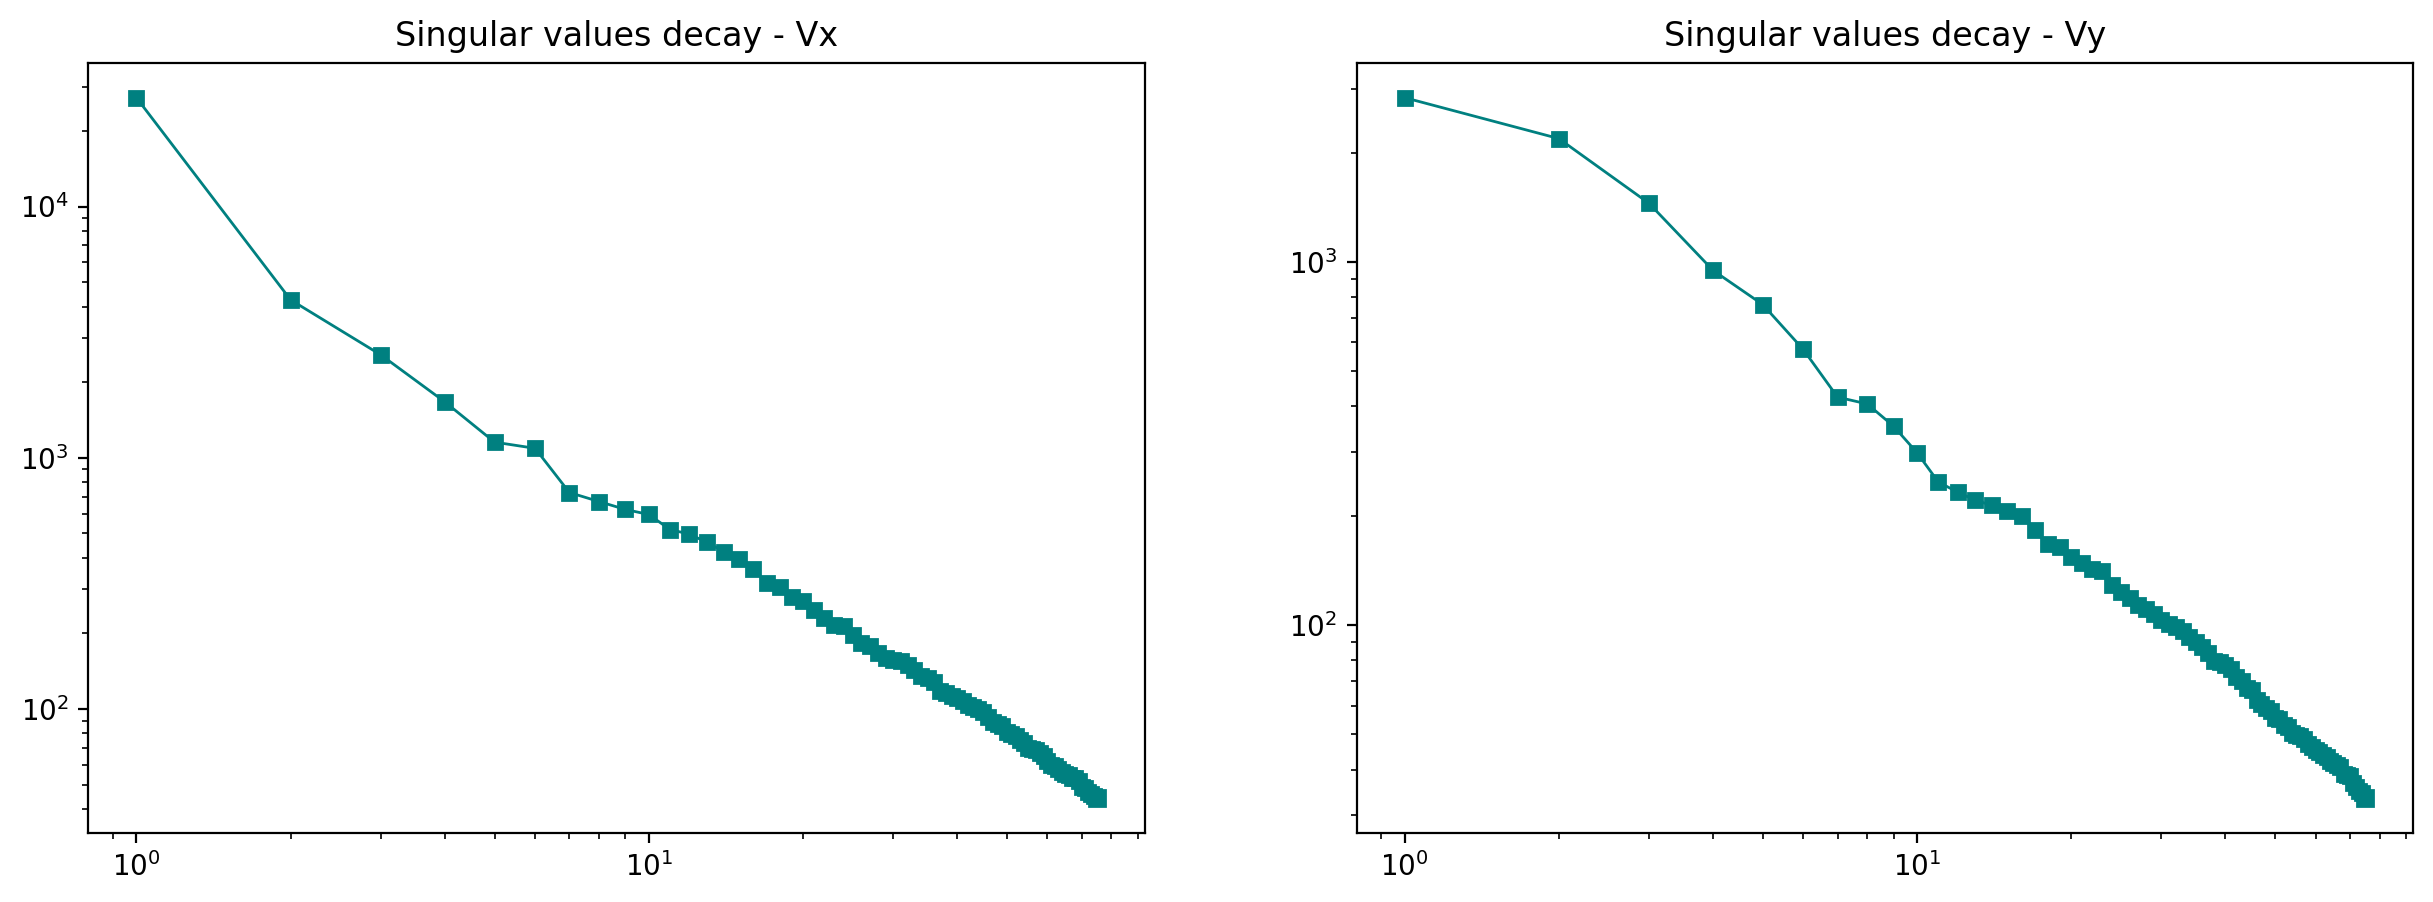

In [78]:
teal = sns.light_palette("teal", 15)
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
plt.plot([i for i in range(1, kvelocity//2 + 1)], Sx, color = teal[14], marker = 's', markersize = 5, linewidth = 1)
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
plt.loglog(kvelocity//2, Sx[kvelocity//2-1], color = teal[14], marker = 's', linestyle = '--')
plt.title("Singular values decay - Vx");

plt.subplot(1, 2, 2)
plt.plot([i for i in range(1, kvelocity//2 + 1)], Sy, color = teal[14], marker = 's', markersize = 5, linewidth = 1)
plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
plt.loglog(kvelocity//2, Sy[kvelocity//2-1], color = teal[14], marker = 's', linestyle = '--')
plt.title("Singular values decay - Vy");

Vxtrain_POD = Vxtrain @ Wx.transpose()
Vxvalid_POD = Vxvalid @ Wx.transpose()
Vxtest_POD = Vxtest @ Wx.transpose()
Vxtrain_reconstructed = Ux @ np.diag(Sx) @ Wx
Vxvalid_reconstructed = Vxvalid @ Wx.transpose() @ Wx
Vxtest_reconstructed = Vxtest @ Wx.transpose() @ Wx

Vytrain_POD = Vytrain @ Wy.transpose()
Vyvalid_POD = Vyvalid @ Wy.transpose()
Vytest_POD = Vytest @ Wy.transpose()
Vytrain_reconstructed = Uy @ np.diag(Sy) @ Wy
Vyvalid_reconstructed = Vyvalid @ Wy.transpose() @ Wy
Vytest_reconstructed = Vytest @ Wy.transpose() @ Wy

In [79]:
print(Ux.shape)
print(Sx.shape)
print(Wx.shape)

(32160, 75)
(75,)
(75, 14472)


In [80]:
print(Vxtrain_POD.shape)

(32160, 75)


In [81]:
x, y = naca0012_coords[:, 0], naca0012_coords[:, 1]
triang = tri.Triangulation(x, y)
x_tri = x[triang.triangles].mean(axis=1)
y_tri = y[triang.triangles].mean(axis=1)
mask = point_in_obstacle(np.vstack([x_tri, y_tri]).transpose(), [(x,y) for x,y in list(zip(naca0012_airfoil_coords[:, 0], naca0012_airfoil_coords[:, 1]))])
triang.set_mask(mask)

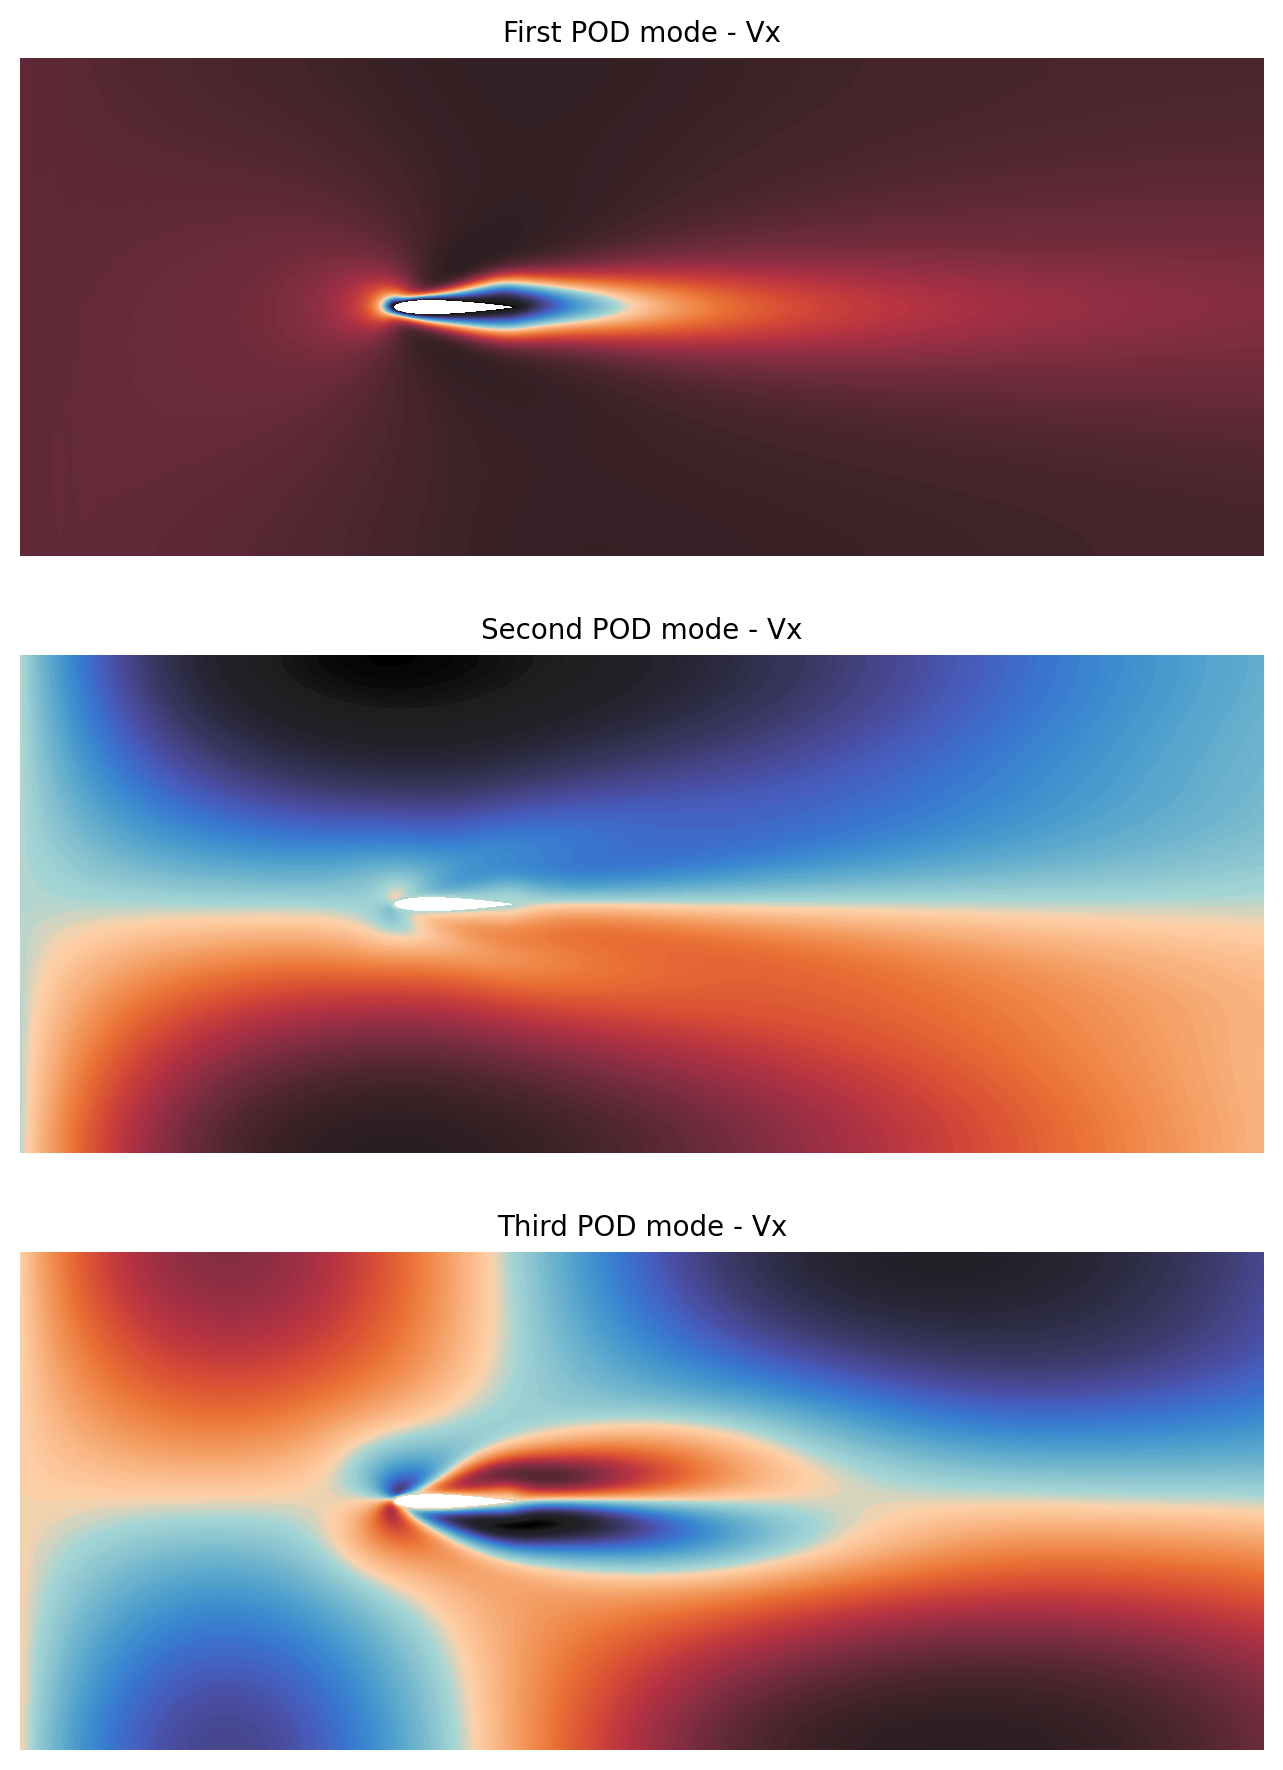

In [82]:
# POD MODES ON THE REFERENCE MESH (PLOT)

from utils.processdata import multiplot

plotlist = [Wx[0], Wx[1], Wx[2]]
def plot_v(v, triang = triang):
    plt.tricontourf(triang, v, cmap = cmap, levels = 200)
    plt.gca().set_aspect("equal")
    add_zoom(zoom = 1.3)
multiplot(plotlist, plot_v, titles = ("First POD mode - Vx", "Second POD mode - Vx", "Third POD mode - Vx"), figsize = (10, 5), vertical = True)

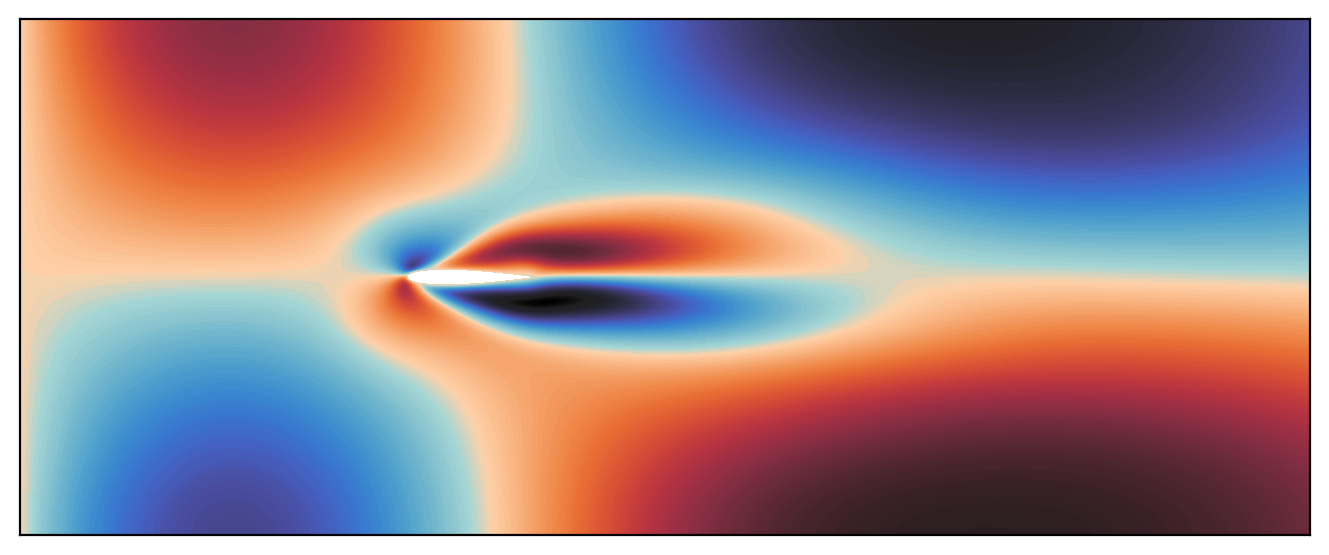

In [83]:
plot_v(Wx[2])
plt.xticks([])
plt.yticks([])
plt.show()

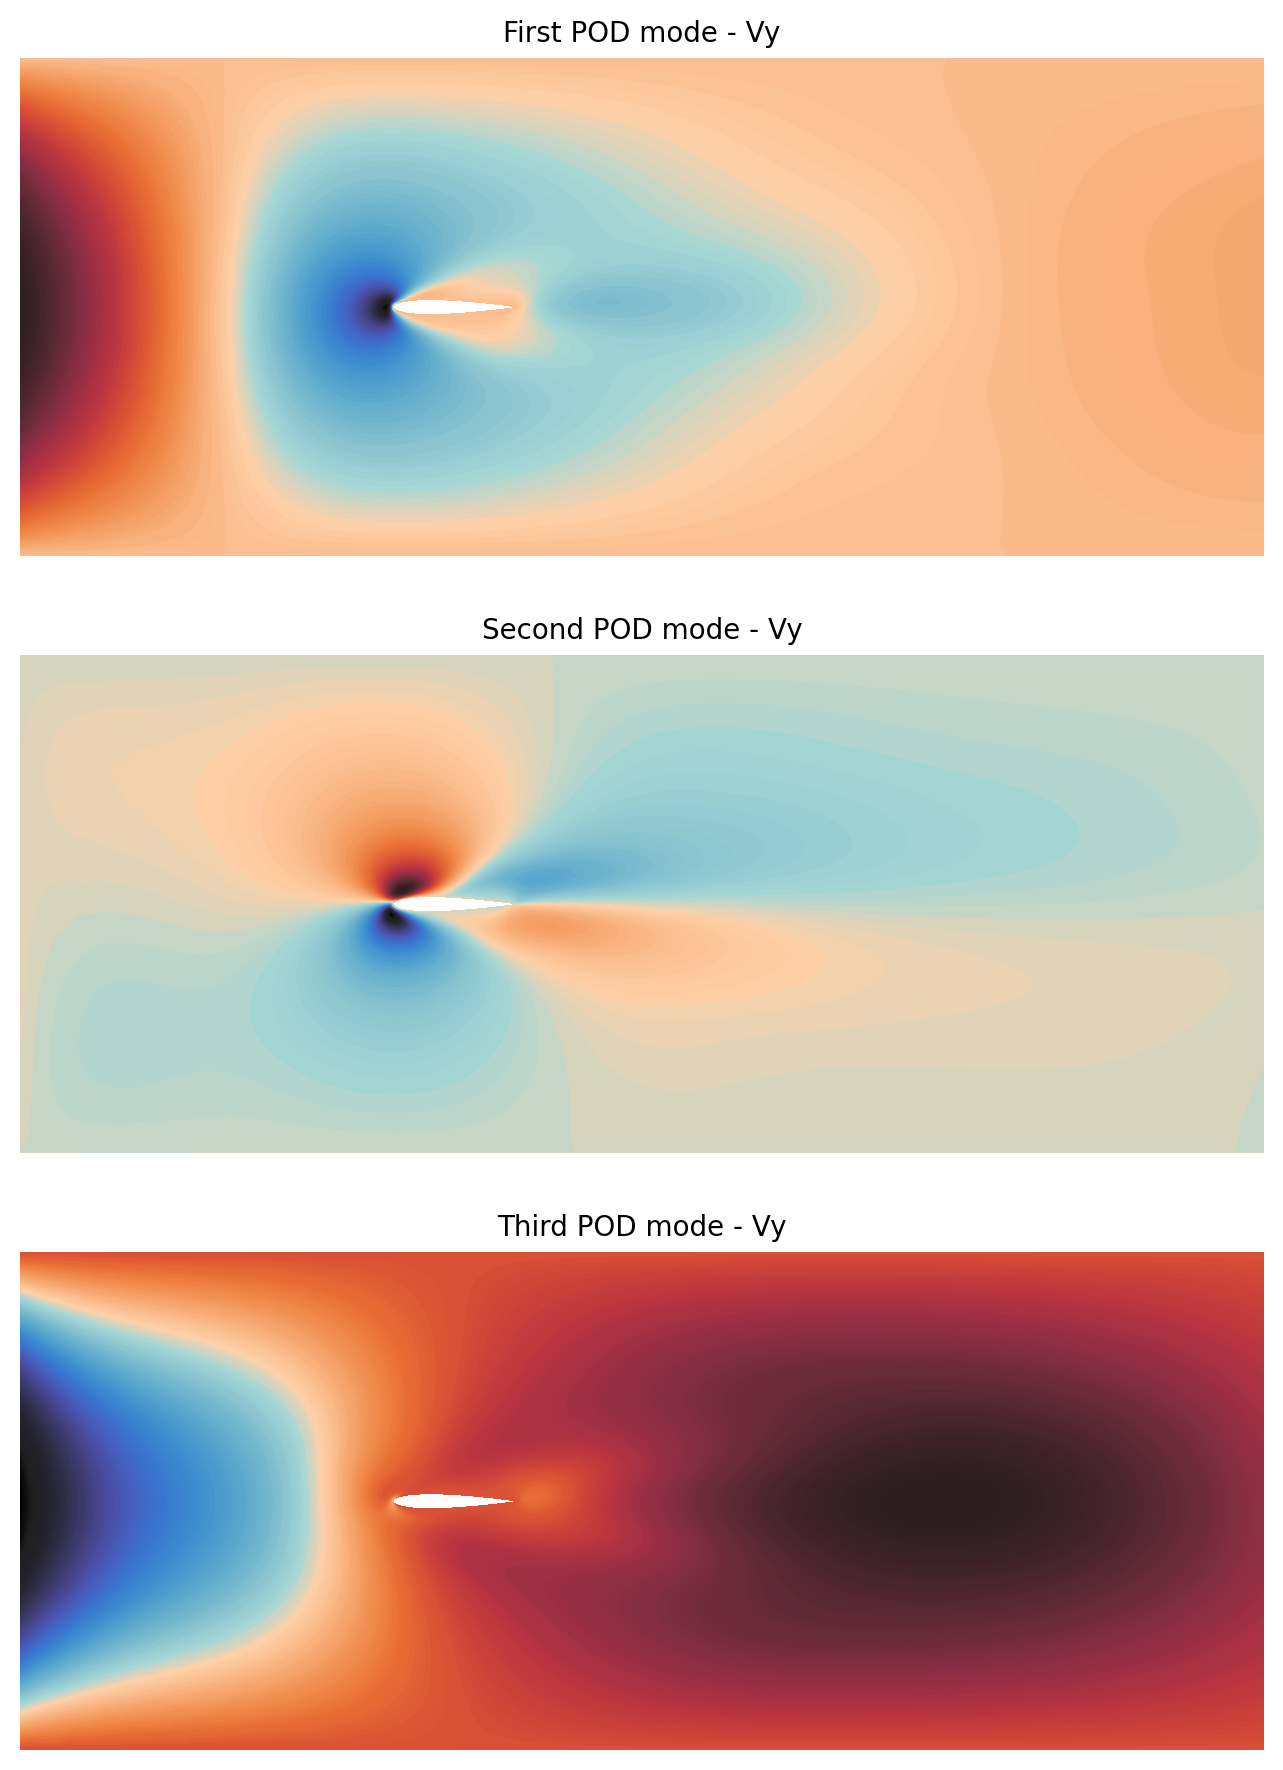

In [84]:
# POD MODES ON THE REFERENCE MESH (PLOT)
plotlist = [Wy[0], Wy[1], Wy[2]]
multiplot(plotlist, plot_v, titles = ("First POD mode - Vy", "Second POD mode - Vy", "Third POD mode - Vy"), figsize = (10, 5), vertical = True)

In [85]:
# SCALING

from sklearn.preprocessing import MinMaxScaler

scalerVx = MinMaxScaler()
scalerVx = scalerVx.fit(Vxtrain_POD)
Vxtrain_POD = scalerVx.transform(Vxtrain_POD)
Vxvalid_POD = scalerVx.transform(Vxvalid_POD)
Vxtest_POD = scalerVx.transform(Vxtest_POD)

scalerVy = MinMaxScaler()
scalerVy = scalerVy.fit(Vytrain_POD)
Vytrain_POD = scalerVy.transform(Vytrain_POD)
Vyvalid_POD = scalerVy.transform(Vyvalid_POD)
Vytest_POD = scalerVy.transform(Vytest_POD)

In [86]:
# RESHAPE MATRICES

Vxtrain = Vxtrain.reshape(ntrain, ntimes, nvelocity)
Vxvalid = Vxvalid.reshape(nvalid, ntimes, nvelocity)
Vxtest = Vxtest.reshape(ntest, ntimes, nvelocity)
Vxtrain_POD = Vxtrain_POD.reshape(ntrain, ntimes, kvelocity//2)
Vxvalid_POD = Vxvalid_POD.reshape(nvalid, ntimes, kvelocity//2)
Vxtest_POD = Vxtest_POD.reshape(ntest, ntimes, kvelocity//2)
Vxtrain_reconstructed = Vxtrain_reconstructed.reshape(ntrain, ntimes, nvelocity)
Vxvalid_reconstructed = Vxvalid_reconstructed.reshape(nvalid, ntimes, nvelocity)
Vxtest_reconstructed = Vxtest_reconstructed.reshape(ntest, ntimes, nvelocity)

Vytrain = Vytrain.reshape(ntrain, ntimes, nvelocity)
Vyvalid = Vyvalid.reshape(nvalid, ntimes, nvelocity)
Vytest = Vytest.reshape(ntest, ntimes, nvelocity)
Vytrain_POD = Vytrain_POD.reshape(ntrain, ntimes, kvelocity//2)
Vyvalid_POD = Vyvalid_POD.reshape(nvalid, ntimes, kvelocity//2)
Vytest_POD = Vytest_POD.reshape(ntest, ntimes, kvelocity//2)
Vytrain_reconstructed = Vytrain_reconstructed.reshape(ntrain, ntimes, nvelocity)
Vyvalid_reconstructed = Vyvalid_reconstructed.reshape(nvalid, ntimes, nvelocity)
Vytest_reconstructed = Vytest_reconstructed.reshape(ntest, ntimes, nvelocity)

In [87]:
# # POD RECONSTRUCTION ERRORS ON TEST DATA

# Vtest_reconstructed = torch.zeros(ntest, ntimes, nvelocity)
# Vtest_reconstructed[:, :, 0 : nvelocity : 2] = Vxtest_reconstructed
# Vtest_reconstructed[:, :, 1 : nvelocity : 2] = Vytest_reconstructed

# print("Mean relative POD reconstruction error on V: %s" % num2p(mre(Vtest, Vtest_reconstructed)))

In [88]:
Vtrain = np.sqrt(Vxtrain**2 + Vytrain**2)
Vtest = np.sqrt(Vxtest**2 + Vytest**2)
Vtest_reconstructed = np.sqrt(Vxtest_reconstructed**2 + Vytest_reconstructed**2)
# calculate error

In [89]:
# print("Mean relative POD reconstruction error on V: %s" % num2p(mre(Vtest, Vtest_reconstructed)))

In [90]:
# def update_coords_and_triang(mesh, params):

#     new_airfoil_coords = generate_airfoil(params[0].item(), params[1].item(), params[2].item(), n_points = N_points, x_le = x_le, y_le = y_le)
#     control_points, displacements = get_control_points_and_displacements(airfoil_coords, new_airfoil_coords, x0 = 0.0, y0 = 0.0, x1 = L, y1 = H, each = 2, step_size = 0.05)
#     mesh = interpolate_mesh(mesh, control_points, displacements)
#     s_cg1 = element("Lagrange", mesh.topology.cell_name(), 1)
#     coords = np.array(functionspace(mesh, s_cg1).tabulate_dof_coordinates())
#     x, y = coords[:, 0], coords[:, 1]
#     triang = tri.Triangulation(x, y)
#     x_tri = x[triang.triangles].mean(axis=1)
#     y_tri = y[triang.triangles].mean(axis=1)
#     mask = point_in_obstacle(np.vstack([x_tri, y_tri]).transpose(), [(x,y) for x,y in list(zip(new_airfoil_coords[:, 0], new_airfoil_coords[:, 1]))])
#     triang.set_mask(mask)

#     return coords, new_airfoil_coords, triang

In [91]:
def update_coords_and_triang(params, coords = naca0012_coords, airfoil_coords = naca0012_airfoil_coords):

    N_points = airfoil_coords.shape[0]
    new_airfoil_coords = generate_airfoil(params[0].item(), params[1].item(), params[2].item(), n_points = N_points, x_le = x_le, y_le = y_le)
    control_points, displacements = get_control_points_and_displacements(airfoil_coords, new_airfoil_coords, x0 = 0.0, y0 = 0.0, x1 = L, y1 = H, each = 2, step_size = 0.05)
    coords = interpolate_coords(coords, control_points, displacements)
    x, y = coords[:, 0], coords[:, 1]
    triang = tri.Triangulation(x, y)
    x_tri = x[triang.triangles].mean(axis=1)
    y_tri = y[triang.triangles].mean(axis=1)
    mask = point_in_obstacle(np.vstack([x_tri, y_tri]).transpose(), [(x,y) for x,y in list(zip(new_airfoil_coords[:, 0], new_airfoil_coords[:, 1]))])
    triang.set_mask(mask)

    return coords, triang

In [92]:
# # FOM vs POD RECONSTRUCTION (PLOTS)

# from utils.processdata import trajectories

# whichtrajectory = 8
# whichtimes = np.arange(0, 200, 10)

# plotlist = [Vtest[whichtrajectory, whichtimes], Vtest_reconstructed[whichtrajectory, whichtimes], Vtest[whichtrajectory, whichtimes] - Vtest_reconstructed[whichtrajectory, whichtimes]]
# params_geo = MUtest[whichtrajectory, 0, 2:]

# # redefine plot_v on new triang
# _, triang = update_coords_and_triang(params_geo)
# def plot_v(v, triang = triang):
#     plt.tricontourf(triang, v, cmap = cmap, levels = 200)
#     plt.gca().set_aspect("equal")
#     add_zoom(zoom = 1.3)

# vmin = min(np.abs(plotlist[i]).min() for i in range(len(plotlist)))
# vmax = max(np.abs(plotlist[i]).max() for i in range(len(plotlist)))

# trajectories(plotlist, plot_v, titles = ("Velocity trajectory", "POD reconstruction", "Reconstruction error"), figsize = (10, 5), vertical = True)

# SHRED-ROM

In [93]:
np.random.seed = 41

In [94]:
# # Simuliamo 5 sensori, ma ad ogni training step le loro coordinate cambiano
nsensors = 5
[xmin, xmax, ymin, ymax] = geometry = [0, L, 0, H]
# sensors_coords_new = np.concatenate((np.random.rand(nsensors, 1) * (xmax - xmin) + xmin, np.random.rand(nsensors, 1) * (ymax - ymin) + ymin), 1, dtype = np.float32)


### Positional encoding

In [95]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [96]:
# train_trajectories = len(idx_train)
# train_trajectories

In [97]:
# sensors_coords_new = torch.from_numpy(sensors_coords_new)
# XY = torch.from_numpy(XY)
# Vxtrain = torch.from_numpy(Vxtrain)

In [98]:
import torch
import torch.nn.functional as F

# --------------------------------------------------
# 1. Definizione della funzione di Fourier Positional Encoding
# --------------------------------------------------
def fourier_encode(x, B):
    """
    Applica il positional encoding Fourier alle coordinate.

    Parametri:
      - x: tensor di shape (n, d) (ad esempio, coordinate spaziali)
      - B: tensor di shape (d, D) contenente le frequenze.

    Restituisce:
      - encoding: tensor di shape (n, 2*D) ottenuto concatenando sin(xB) e cos(xB).
    """
    # Proiezione: x @ B produce un tensore di shape (n, D)
    x_proj = 2 * torch.pi * x @ B
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

# --------------------------------------------------
# 2. Setup dei parametri e degli input
# --------------------------------------------------
d = 2   # dimensione originale delle coordinate (x, y)
D = 16  # dimensione scelta per la proiezione (puoi variare questo parametro)

# Matrice di frequenze per il Fourier encoding (può essere fissata oppure resa learnable)
B = torch.randn(d, D).to(device)

# # --------------------------------------------------
# # 3. Calcolo degli encoding Fourier per i nodi e per i sensori
# # --------------------------------------------------
# # Calcolo dell'encoding per i sensori: shape (nsensors, 2*D)
# sensor_encodings = fourier_encode(sensors_coords_new, B)  # comune a tutte le traiettorie

# # Calcolo dell'encoding per i nodi per tutte le traiettorie.
# # Risultato atteso: (ntraj, nvelocity, 2*D)
# # Possiamo calcolarlo in modo vettorizzato:
# node_encodings_train = fourier_encode(XY[idx_train].view(-1, d), B)
# node_encodings_train = node_encodings_train.view(len(idx_train), nvelocity, 2 * D)

# node_encodings_valid = fourier_encode(XY[idx_valid].view(-1, d), B)
# node_encodings_valid = node_encodings_valid.view(len(idx_valid), nvelocity, 2 * D)

# node_encodings_test = fourier_encode(XY[idx_test].view(-1, d), B)
# node_encodings_test = node_encodings_test.view(len(idx_test), nvelocity, 2 * D)

In [99]:
# # --------------------------------------------------
# # 4. Calcolo dei pesi di similarità e interpolazione
# # --------------------------------------------------
# # Per ogni traiettoria, calcoliamo la similarità fra i sensori e i nodi.
# # Usiamo broadcasting per ottenere in una sola operazione:
# #
# #   sensor_encodings: (nsensors, 2*D)
# #   node_encodings: (ntraj, nvelocity, 2*D)
# #
# # Vogliamo ottenere similarity: (ntraj, nsensors, nvelocity)
# # facendo, per ogni traiettoria i e per ogni sensore j,
# #   similarity[i,j] = sensor_encodings[j] · node_encodings[i].T
# sensor_encodings_expanded = sensor_encodings.unsqueeze(0)  # shape: (1, nsensors, 2*D)


In [100]:
# # Trasponiamo l'encoding dei nodi per il prodotto scalare:
# node_encodings_t = node_encodings_train  # shape: (ntraj, nvelocity, 2*D)
# similarity = torch.matmul(sensor_encodings_expanded, node_encodings_t.transpose(1,2))
# # similarity: (ntraj, nsensors, nvelocity)

# # Otteniamo i pesi (softmax sul nodo-dimensione, ovvero dim=2)
# weights = F.softmax(similarity, dim=2)  # shape: (ntraj, nsensors, nvelocity)

# # Ora, per ogni traiettoria e per ogni timestep, eseguiamo la media pesata dei valori dei nodi.
# # Vxtrain ha shape: (ntraj, ntimes, nvelocity)
# # Per eseguire la moltiplicazione, trasponiamo weights in modo che abbiano shape (ntraj, nvelocity, nsensors)
# weights_t = weights.transpose(1,2)  # shape: (ntraj, nvelocity, nsensors)


In [101]:

# # Reshape Vxtrain per includere una dimensione batch 3D: (ntraj*ntimes, 1, nvelocity)
# Vxtrain_reshaped = Vxtrain.view(-1, nvelocity).unsqueeze(1)

# # Replichiamo i pesi per ogni timestep all'interno della traiettoria:
# # weights_t ha shape: (ntraj, nvelocity, nsensors)
# # Ripetiamo ogni matrice di pesi ntimes volte lungo l'asse batch:
# weights_expanded = weights_t.repeat_interleave(ntimes, dim=0)  # shape: (ntraj*ntimes, nvelocity, nsensors)


In [102]:
# # Ora possiamo fare la moltiplicazione batch-matrix:
# Vx_interp_flat = torch.bmm(Vxtrain_reshaped, weights_expanded)  # shape: (ntraj*ntimes, 1, nsensors)
# # Rimuoviamo la dimensione 1 e rimodelliamo:
# sensors_data_train = Vx_interp_flat.squeeze(1).view(train_trajectories, ntimes, nsensors)


In [103]:
# # ad ogni step:
# # - genero sensor_coords_new
# sensor_encodings_expanded = fourier_encode(sensors_coords_new, B).unsqueeze(0)  # shape: (1, nsensors, 2*D)

# # - per train, valid e test:
# similarity = torch.matmul(sensor_encodings_expanded, node_encodings_t.transpose(1,2))
# weights_t = F.softmax(similarity, dim=2).transpose(1,2)  # shape: (ntraj, nvelocity, nsensors)
# weights_expanded = weights_t.repeat_interleave(ntimes, dim=0)  # shape: (ntraj*ntimes, nvelocity, nsensors)
# sensors_data_flat = torch.bmm(Vxtrain_reshaped, weights_expanded)  # shape: (ntraj*ntimes, 1, nsensors)
# sensors_data = Vx_interp_flat.squeeze(1).view(train_trajectories, ntimes, nsensors)

In [104]:
# def generate_sensor_data(sensors_coords_new, B):

    # sensor_encodings_expanded = fourier_encode(sensors_coords_new, B).unsqueeze(0)  # shape: (1, nsensors, 2*D)

    # # - per train, valid e test:
    # similarity = torch.matmul(sensor_encodings_expanded, node_encodings_t.transpose(1,2))
    # weights_t = F.softmax(similarity, dim=2).transpose(1,2)  # shape: (ntraj, nvelocity, nsensors)
    # weights_expanded = weights_t.repeat_interleave(ntimes, dim=0)  # shape: (ntraj*ntimes, nvelocity, nsensors)
    # sensors_data_flat = torch.bmm(Vxtrain_reshaped, weights_expanded)  # shape: (ntraj*ntimes, 1, nsensors)
    # sensors_data = Vx_interp_flat.squeeze(1).view(train_trajectories, ntimes, nsensors)

In [105]:
# scatter_array(naca0012_coords, s = 0.1)
# scatter_array(sensors_coords_new, s = 50)
# add_zoom()

In [106]:
# # TRAJECTORY WITH SENSORS (PLOT)
# import matplotlib as mpl

# def trajectory_with_sensors(vt, params_geo, sensors_coordinates, sensors_values, title = None):
#     """
#     Velocity trajectory with sensors
#     Input: velocity trajectory with dimension (ntimes, nvelocity), geometric parameters and and the selected sensor indices
#     """
#     # redefine plot_v on new triang
#     coords, triang = update_coords_and_triang(params_geo)
#     norm = mpl.colors.Normalize(vmin = vt.min().item(), vmax = vt.max().item())
#     def plot_v(v, triang = triang):
#         plt.tricontourf(triang, v, cmap = cmap, levels = 200, norm = norm)
#         plt.gca().set_aspect("equal")
#         add_zoom(zoom = 1.3)

#     # sensors_coordinates = coords[idx_sensors, :2]
#     nsensors = sensors_coordinates.shape[0]

#     for i in range(vt.shape[0]):
#         plt.figure(figsize=(10,10))
#         plot_v(vt[i])
#         for k in np.arange(nsensors):
#             plt.scatter(sensors_coordinates[k, 0], sensors_coordinates[k, 1], c = sensors_values[i, k],
#                         facecolors='none',   # interno trasparente
#                         edgecolors='white',
#                         marker = 'o', norm = norm, s = 100, cmap = cmap) # , mec = 'black', ms = 8, mew = 1.5)
#         plt.xlim((-0.1,10.1))
#         plt.title(title)
#         plt.axis('off')
#         display(plt.gcf())
#         plt.close()
#         clc(wait=True)

# whichtrajectory = 3
# whichtimes = np.arange(0, 200, 10)

# trajectory_with_sensors(Vxtrain[whichtrajectory, whichtimes],
#                         MUtrain[whichtrajectory, 0, 2:],
#                         sensors_coordinates=sensors_coords.detach().numpy(),
#                         sensors_values= sensors_data_train.detach().numpy()[whichtrajectory, whichtimes],
#                         title = "Velocity trajectory with sensors")

### Delaunay

In [113]:
# import numpy as np
# from scipy.spatial import Delaunay
# import scipy.sparse as sp
# from joblib import Parallel, delayed  # Per la parallelizzazione

# def compute_interpolation_matrix_from_tri(tri, sensors_coords):
#     """
#     Data una triangolazione Delaunay precomputata e nuove coordinate dei sensori,
#     calcola la matrice di interpolazione M (shape: (nsensors, N_nodes)).
#     """
#     simplex = tri.find_simplex(sensors_coords)
#     if np.any(simplex < 0):
#         raise ValueError("Uno o più sensori cadono fuori dalla triangolazione!")

#     X = tri.transform[simplex, :2]
#     delta = sensors_coords - tri.transform[simplex, 2]
#     bary = np.einsum('ijk,ik->ij', X, delta)
#     bary = np.hstack((bary, 1 - bary.sum(axis=1, keepdims=True)))
#     vertices = tri.simplices[simplex]

#     nsensors = sensors_coords.shape[0]
#     N_nodes = tri.points.shape[0]
#     rows = np.repeat(np.arange(nsensors), 3)
#     cols = vertices.flatten()
#     data = bary.flatten()
#     # Crea la matrice in formato sparse
#     M = sp.coo_matrix((data, (rows, cols)), shape=(nsensors, N_nodes)).tocsr()
#     return M

# def process_trajectory(i, vx_dataset_i, tri, sensors_coords):
#     """
#     Processa una traiettoria (tutti i timestep insieme) utilizzando
#     l'interpolazione vettorizzata, calcolando M una volta per traiettoria,
#     e applicandola a tutti i timestep in batch.
#     """
#     # Calcola la matrice di interpolazione per la traiettoria corrente
#     M = compute_interpolation_matrix_from_tri(tri, sensors_coords)
#     # Converto in denso: dato che nsensors è molto piccolo, questa operazione è computazionalmente vantaggiosa
#     M_dense = M.toarray()  # shape: (nsensors, N_nodes)

#     # vx_dataset_i ha shape (ntimes, N_nodes)
#     # Effettuiamo il prodotto in batch: (M_dense @ vx_dataset_i.T).T
#     # cioè: per ogni timestep calcoliamo M_dense dot (vettore di nodi) usando un prodotto matrice–matrice.
#     vx_interp_i = (M_dense @ vx_dataset_i.T).T  # risultato shape: (ntimes, nsensors)
#     return vx_interp_i

# def interpolate_dataset_with_dynamic_sensors_parallel(vx_dataset, triangulations, sensors_coords, static_mesh=True, n_jobs=-1):
#     """
#     Interpola il dataset vx (shape: [ntraj, ntimes, N_nodes]) in parallelo utilizzando la triangolazione precomputata
#     e la vettorizzazione per ciascuna traiettoria.

#     Parametri:
#       - vx_dataset: array di shape (ntraj, ntimes, N_nodes)
#       - triangulations: se static_mesh==True, lista di triangolazioni di lunghezza ntraj;
#           altrimenti, struttura 2D (ntraj, ntimes)
#       - sensors_coords: array di shape (nsensors, 2) fornito al training step corrente.
#       - n_jobs: numero di processi paralleli (-1 usa tutti i core disponibili).

#     Restituisce:
#       - vx_interp: array di shape (ntraj, ntimes, nsensors)
#     """
#     ntraj, ntimes, _ = vx_dataset.shape

#     # Parallelizza lungo le traiettorie
#     results = Parallel(n_jobs=n_jobs)(
#         delayed(process_trajectory)(i, vx_dataset[i], triangulations[i], sensors_coords)
#         for i in range(ntraj)
#     )


#     # Aggrega i risultati in un array finale
#     vx_interp = np.stack(results, axis=0)
#     return vx_interp

In [114]:

# triangulations = [Delaunay(XY[i]) for i in range(ntrajectories)]


In [115]:
# triangulations_train = [triangulations[i] for i in idx_train]
# triangulations_valid = [triangulations[i] for i in idx_valid]
# triangulations_test = [triangulations[i] for i in idx_test]

In [116]:
# sensors_data_train = interpolate_dataset_with_dynamic_sensors_parallel(Vxtrain, triangulations_train, sensors_coords_new, static_mesh=True, n_jobs=-1)
# sensors_data_valid = interpolate_dataset_with_dynamic_sensors_parallel(Vxvalid, triangulations_valid, sensors_coords_new, static_mesh=True, n_jobs=-1)
# sensors_data_test = interpolate_dataset_with_dynamic_sensors_parallel(Vxtest, triangulations_test, sensors_coords_new, static_mesh=True, n_jobs=-1)

In [117]:
# scatter_array(naca0012_coords, s = 0.1)
# scatter_array(sensors_coords_new, s = 50)
# add_zoom()

In [118]:
# importlib.reload(utils.models_sensors)
# from utils.models_sensors import interpolate_data, get_interpolators

In [119]:
# id_max_traj = ntrajectories
# sensors_data_train = interpolate_data(Vxtrain[idx_train], XY[idx_train], sensors_coords)
# sensors_data_valid = interpolate_data(Vxtrain[idx_valid], XY[idx_valid], sensors_coords)
# sensors_data_test = interpolate_data(Vxtrain[idx_test], XY[idx_test], sensors_coords)

In [120]:
# # LOAD SENSOR DATA

# nsensors = 3
# idx_sensors = torch.load('FlowAroundObstacle_idx_sensors_velocity.pt', weights_only = False)

# sensors_data_train = Vxtrain[:,:,idx_sensors]
# sensors_data_valid = Vxvalid[:,:,idx_sensors]
# sensors_data_test = Vxtest[:,:,idx_sensors]

In [121]:
# # TRAJECTORY WITH SENSORS (PLOT)

# def trajectory_with_sensors(vt, params_geo, idx_sensors, title = None):
#     """
#     Velocity trajectory with sensors
#     Input: velocity trajectory with dimension (ntimes, nvelocity), geometric parameters and and the selected sensor indices
#     """
#     # redefine plot_v on new triang
#     coords, triang = update_coords_and_triang(params_geo)
#     def plot_v(v, triang = triang):
#         plt.tricontourf(triang, v, cmap = cmap, levels = 200)
#         plt.gca().set_aspect("equal")
#         add_zoom(zoom = 1.3)

#     sensors_coordinates = coords[idx_sensors, :2]

#     for i in range(vt.shape[0]):
#         plt.figure(figsize=(10,10))
#         plot_v(vt[i])
#         for k in np.arange(nsensors):
#             plt.plot(sensors_coordinates[k, 0], sensors_coordinates[k, 1], 'o', mfc = 'magenta', mec = 'black', ms = 8, mew = 1.5)
#         plt.xlim((-0.1,10.1))
#         plt.title(title)
#         plt.axis('off')
#         display(plt.gcf())
#         plt.close()
#         clc(wait=True)

# whichtrajectory = 40
# whichtimes = np.arange(0, 200, 10)

# trajectory_with_sensors(Vxtrain[whichtrajectory, whichtimes], MUtrain[whichtrajectory, 0, 2:], idx_sensors, title = "Velocity trajectory with sensors")

In [122]:
# # TRAJECTORY WITH SENSORS (PLOT)
# import matplotlib as mpl

# def trajectory_with_sensors(vt, params_geo, sensors_coordinates, sensors_values, title = None):
#     """
#     Velocity trajectory with sensors
#     Input: velocity trajectory with dimension (ntimes, nvelocity), geometric parameters and and the selected sensor indices
#     """
#     # redefine plot_v on new triang
#     coords, triang = update_coords_and_triang(params_geo)
#     norm = mpl.colors.Normalize(vmin = vt.min().item(), vmax = vt.max().item())
#     def plot_v(v, triang = triang):
#         plt.tricontourf(triang, v, cmap = cmap, levels = 200, norm = norm)
#         plt.gca().set_aspect("equal")
#         add_zoom(zoom = 1.3)

#     # sensors_coordinates = coords[idx_sensors, :2]
#     nsensors = sensors_coordinates.shape[0]

#     for i in range(vt.shape[0]):
#         plt.figure(figsize=(10,10))
#         plot_v(vt[i])
#         for k in np.arange(nsensors):
#             plt.scatter(sensors_coordinates[k, 0], sensors_coordinates[k, 1], c = sensors_values[i, k],
#                         facecolors='none',   # interno trasparente
#                         edgecolors='white',
#                         marker = 'o', norm = norm, s = 100, cmap = cmap) # , mec = 'black', ms = 8, mew = 1.5)
#         plt.xlim((-0.1,10.1))
#         plt.title(title)
#         plt.axis('off')
#         display(plt.gcf())
#         plt.close()
#         clc(wait=True)

# whichtrajectory = 3
# whichtimes = np.arange(0, 200, 10)

# trajectory_with_sensors(Vxtrain[whichtrajectory, whichtimes],
#                         MUtrain[whichtrajectory, 0, 2:],
#                         sensors_coordinates=sensors_coords_new,
#                         sensors_values= sensors_data_train[whichtrajectory, whichtimes],
#                         title = "Velocity trajectory with sensors")

### QR_Pivoting

In [123]:
# import scipy

In [124]:
# r = kvelocity//2
# n_sensors = kvelocity//2
# if (n_sensors <= r):
#     Q, R, gamma = scipy.linalg.qr(Wx, pivoting = True)
# else:
#     Q, R, gamma = scipy.linalg.qr(Wx.transpose() @ Wx, pivoting = True)

# n_sensors_real = 10
# gamma = gamma[:n_sensors_real] # undersampled

In [125]:
# A = np.diag(Sx) @ Ux.transpose()
# Wx_t = Wx.transpose()

In [126]:
# # sensors_data_train = Vxtrain.numpy()[:, :, gamma]
# sensors_data_train = Vxtrain[:, :, gamma]
# Y = sensors_data_train.reshape(-1, n_sensors_real).transpose()
# if n_sensors_real == r:
#     A_hat = np.linalg.inv(Wx_t[gamma, :]) @ Y
# else:
#     A_hat = np.linalg.pinv(Wx_t[gamma, :]) @ Y # Moore-Penrose pseudo-inverse
# Vxtrain_qrpiv = (Wx_t @ A_hat).transpose().reshape(len(idx_train), ntimes, nvelocity)

# sensors_data_valid = Vxvalid[:, :, gamma]
# Y = sensors_data_valid.reshape(-1, n_sensors_real).transpose()
# if n_sensors_real == r:
#     A_hat = np.linalg.inv(Wx_t[gamma, :]) @ Y
# else:
#     A_hat = np.linalg.pinv(Wx_t[gamma, :]) @ Y # Moore-Penrose pseudo-inverse
# Vxvalid_qrpiv = (Wx_t @ A_hat).transpose().reshape(len(idx_valid), ntimes, nvelocity)

# sensors_data_test = Vxtest[:, :, gamma]
# Y = sensors_data_test.reshape(-1, n_sensors_real).transpose()
# if n_sensors_real == r:
#     A_hat = np.linalg.inv(Wx_t[gamma, :]) @ Y
# else:
#     A_hat = np.linalg.pinv(Wx_t[gamma, :]) @ Y # Moore-Penrose pseudo-inverse
# Vxtest_qrpiv = (Wx_t @ A_hat).transpose().reshape(len(idx_test), ntimes, nvelocity)


In [127]:
# # FOM vs POD RECONSTRUCTION VS QR-PIVOTING

# from utils.processdata import trajectories, trajectories_with_sensors

# whichtrajectory = 8
# whichtimes = np.arange(0, 200, 10)

# plotlist = [Vtest[whichtrajectory, whichtimes], Vtest_reconstructed[whichtrajectory, whichtimes], Vxtest_qrpiv[whichtrajectory, whichtimes]]
# params_geo = MUtest[whichtrajectory, 0, 2:]

# # redefine plot_v on new triang
# coords, triang = update_coords_and_triang(params_geo)
# sensors_coordinates = coords[gamma, :2]
# def plot_v(v, triang = triang):
#     plt.tricontourf(triang, v, cmap = cmap, levels = 200)
#     plt.gca().set_aspect("equal")
#     add_zoom(zoom = 1.3)

# vmin = min(np.abs(plotlist[i]).min() for i in range(len(plotlist)))
# vmax = max(np.abs(plotlist[i]).max() for i in range(len(plotlist)))

# trajectories_with_sensors(plotlist, plot_v, gamma, sensors_coordinates, titles = ("Velocity trajectory", "POD reconstruction", "QR-pivoting reconstruction"), figsize = (10, 5), vertical = True)

### Sensor interpolation and training

In [107]:
class SensorDataInterpolator(torch.nn.Module):
    def __init__(self, B, device = device):
        """
        XY: torch.Tensor di shape (ntraj, nvelocity, 2) -> coordinate dei nodi per traiettoria
        Vxtrain: torch.Tensor di shape (ntraj, ntimes, nvelocity) -> valori sui nodi (statici nel tempo)
        B: torch.Tensor di shape (2, D) -> matrice di frequenze per il Fourier encoding
        """
        super().__init__()
        self.B = B
        self.device = device

    def forward(self, sensors_coords, Vxtrain, node_encodings):
        """
        sensors_coords: torch.Tensor di shape (nsensors, 2  D) (trainable)

        Restituisce:
           sensor_data: tensor di shape (ntraj, ntimes, nsensors) ottenuto come interpolazione differenziabile
           dei valori Vxtrain nei nuovi punti dati dai sensors_coords_encoded.
        """

        ntraj, nvelocity, ntimes = Vxtrain.shape

        nsensors = sensors_coords.shape[0]
        # Calcola l'encoding dei sensori
        sensor_encodings = fourier_encode(sensors_coords, self.B).to(self.device)  # shape: (nsensors, 2*D)
        # node_encodings: (ntraj, nvelocity, 2*D); vogliamo il prodotto scalare tra
        # ogni sensore ed ogni nodo per ogni traiettoria.
        # Risulta una similarità di shape: (ntraj, nsensors, nvelocity)

        # nsensors = sensor_encodings.shape[0]

        sensor_encodings_expanded = sensor_encodings.unsqueeze(0)  # (1, nsensors, 2*D)
        similarity = torch.matmul(sensor_encodings_expanded, node_encodings.transpose(1,2)).to(self.device)

        # Softmax lungo l'asse dei nodi per ottenere i pesi
        weights = F.softmax(similarity, dim=2).to(self.device)  # shape: (ntraj, nsensors, nvelocity)
        # Per eseguire la somma pesata sui valori:
        # Vxtrain: (ntraj, ntimes, nvelocity)
        # Per la moltiplicazione batch, bisogna trasporre i pesi: (ntraj, nvelocity, nsensors)
        weights_t = weights.transpose(1,2)  # (ntraj, nvelocity, nsensors)

        sensor_vals = torch.matmul(Vxtrain, weights_t).to(self.device)

        return sensor_vals

In [108]:
class ReflectWithGradFlip(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, L, H):
        """
        input: tensor di shape (n, 2), coordinate dei sensori.
        L, H: valori scalari (float) dei limiti per x ed y.
        """
        # Salviamo l'input in ctx per poterlo usare in backward.
        ctx.save_for_backward(input)
        ctx.L = L
        ctx.H = H

        # Calcoliamo il valore riflesso per x e y.
        # Usiamo la formula: r(x) = L - | L - (x mod (2L)) |
        x = input[:, 0]
        y = input[:, 1]
        # Calcoliamo "modulo" con torch.remainder
        r_x = L - torch.abs(L - torch.remainder(x, 2 * L))
        r_y = H - torch.abs(H - torch.remainder(y, 2 * H))
        output = torch.stack([r_x, r_y], dim=1)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        # Recupera l'input originale
        input, = ctx.saved_tensors
        L = ctx.L
        H = ctx.H

        # Inizializza il gradiente per input con quello in grad_output
        grad_input = grad_output.clone()

        # Definisci maschere per le coordinate fuori dai limiti:
        mask_x = (input[:, 0] < 0) | (input[:, 0] > L)
        mask_y = (input[:, 1] < 0) | (input[:, 1] > H)
        # Inverte il segno del gradiente nelle coordinate fuori dai limiti:
        grad_input[:, 0] = torch.where(mask_x, -grad_input[:, 0], grad_input[:, 0])
        grad_input[:, 1] = torch.where(mask_y, -grad_input[:, 1], grad_input[:, 1])
        # Non generiamo gradiente per L o H (None)
        return grad_input, None, None

def reflect_with_grad_flip(x, L, H):
    """
    Funzione wrapper per applicare la reflection con inversione dei gradienti
    per le coordinate fuori dai limiti.
    x: tensor di shape (n, 2)
    L, H: limiti (float)
    """
    return ReflectWithGradFlip.apply(x, L, H)


In [109]:
class GateGradient(torch.autograd.Function):
    @staticmethod
    def forward(ctx, x, flag):
        """
        x: input tensor
        flag: scalare (0.0 oppure 1.0); in forward è ignorato, in backward regola il gradiente
        """
        ctx.flag = flag
        return x

    @staticmethod
    def backward(ctx, grad_output):
        # In fase backward moltiplica il gradiente per il flag.
        return grad_output * ctx.flag, None

def gate_gradient(x, flag):
    return GateGradient.apply(x, flag)


In [110]:
# import torch
# import torch.nn as nn
# import torch.nn.functional as F

# class FourierDecoder(nn.Module):
#     def __init__(self, encoding_dim, output_dim, hidden_dim=128):
#         super(FourierDecoder, self).__init__()
#         self.fc1 = nn.Linear(encoding_dim, hidden_dim)
#         self.fc2 = nn.Linear(hidden_dim, hidden_dim)
#         self.fc3 = nn.Linear(hidden_dim, output_dim)

#     def forward(self, z):
#         x = F.relu(self.fc1(z))
#         x = F.relu(self.fc2(x))
#         return self.fc3(x)
# n_samples = 10000    # numero di punti
# fourier_dim = D     # dimensione encoding per ciascuna coordinata

# # 1. Genera punti casuali in [0, L] x [0, H]
# x = torch.empty(n_samples, 2)
# x[:, 0] = torch.rand(n_samples) * L
# x[:, 1] = torch.rand(n_samples) * H

# z = fourier_encode(x, B.cpu())  # (n_samples, 2*D)
# decoder = FourierDecoder(encoding_dim=z.shape[-1], output_dim=2)
# optimizer = torch.optim.Adam(decoder.parameters(), lr=1e-3)
# loss_fn = nn.MSELoss()

# for epoch in range(4000):
#     x_pred = decoder(z)
#     loss = loss_fn(x_pred, x)
#     optimizer.zero_grad()
#     loss.backward()
#     optimizer.step()
#     if epoch % 100 == 0:
#         print(f"Epoch {epoch}, Loss: {loss.item():.6f}")


### Creazione timeseries coordinate sensori

In [132]:
# # EXTRACT SENSOR DATA (SKIP THIS CELL IF DATA ALREADY AVAILABLE)
# idx_sensors = np.random.choice(nvelocity, size = nsensors, replace = False)

# sensors_data_train = Vxtrain[:,:,idx_sensors]
# sensors_data_valid = Vxvalid[:,:,idx_sensors]
# sensors_data_test = Vxtest[:,:,idx_sensors]

In [133]:
# # va bene solo per posizioni non trainabili (di fatto inutile)

# sensors_coords_train = np.tile(np.expand_dims(XY[idx_train][:, idx_sensors], 1), reps = (1, ntimes, 1, 1))
# sensors_data_train = np.concatenate((sensors_coords_train, np.expand_dims(sensors_data_train, -1)), -1).reshape((len(idx_train), ntimes, -1))
# sensors_data_train = torch.from_numpy(sensors_data_train).to(torch.float).to(device)

# sensors_coords_valid = np.tile(np.expand_dims(XY[idx_valid][:, idx_sensors], 1), reps = (1, ntimes, 1, 1))
# sensors_data_valid = np.concatenate((sensors_coords_valid, np.expand_dims(sensors_data_valid, -1)), -1).reshape((len(idx_valid), ntimes, -1))
# sensors_data_valid = torch.from_numpy(sensors_data_valid).to(torch.float).to(device)

# sensors_coords_test = np.tile(np.expand_dims(XY[idx_test][:, idx_sensors], 1), reps = (1, ntimes, 1, 1))
# sensors_data_test = np.concatenate((sensors_coords_test, np.expand_dims(sensors_data_test, -1)), -1).reshape((len(idx_test), ntimes, -1))
# sensors_data_test = torch.from_numpy(sensors_data_test).to(torch.float).to(device)

In [134]:
# del  sensors_coords_train, sensors_coords_valid, sensors_coords_test, sensors_data_train, sensors_data_valid, sensors_data_test

### Training sensori 2 (rigenero tutto il dataset con coordinate sensori)

In [111]:
import torch
from copy import deepcopy
from IPython.display import clear_output as clc
from utils.processdata import mse, mre, num2p

import torch.nn.functional as F
from utils.processdata import TimeSeriesDataset, Padding

In [112]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [116]:
Vxtrain_POD = torch.from_numpy(Vxtrain_POD)
Vxvalid_POD = torch.from_numpy(Vxvalid_POD)
Vxtest_POD = torch.from_numpy(Vxtest_POD)

Vytrain_POD = torch.from_numpy(Vytrain_POD)
Vyvalid_POD = torch.from_numpy(Vyvalid_POD)
Vytest_POD = torch.from_numpy(Vytest_POD)

MUtrain = torch.from_numpy(MUtrain)
MUvalid = torch.from_numpy(MUvalid)
MUtest = torch.from_numpy(MUtest)


In [113]:
# Assume mesh_coords is an array of shape (nvelocity, coord_dim) with node coordinates
# and idx_sensors is already defined (indices of selected sensors)
coord_dim = 2  # e.g. 2 for 2D
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lag = 50

In [114]:
# dopo Vxtrain = Vxfull[idx_train]
ntrain = len(idx_train)    # es. 64
nvalid = len(idx_valid)
ntest = len(idx_test)

# 1) genera indici random sulle 80 traiettorie
indices = np.stack([
    np.random.choice(nvelocity, nsensors, replace=False)
    for _ in range(ntrajectories)
], axis=0)    # (80,5)

# 2) ma per train prendi solo quelli di idx_train
sensors_idx_train = indices[idx_train]       # (ntrain,5)

# 3) ricostruisci un "traj_idx" che vada da 0 a ntrain-1
traj_idx_train    = np.arange(ntrain)[:, None, None]   # (ntrain,1,1)
time_idx          = np.arange(ntimes)[None, :, None]   # (1,201,1)
sensors_idx_train = sensors_idx_train[:, None, :]      # (ntrain,1,5)

# 4) slicedata su Vxtrain
sensors_data_train = torch.from_numpy(
    Vxtrain[traj_idx_train, time_idx, sensors_idx_train]
).float()   # → (ntrain,201,5)


In [117]:
train_hist = Padding(sensors_data_train, lag).transpose(1,2) #.to(device) # (N_samples, nsensors, lag)
train_out = Padding(torch.cat((Vxtrain_POD, Vytrain_POD, MUtrain[:, :, 0].unsqueeze(2)), 2), 1).squeeze(1) #.to(device) # (N_samples, nvelocity)

# Number of samples
N_train = train_hist.shape[0]

# Expand coords to per-sample
sensor_coords_exp = torch.from_numpy(np.repeat(XY[np.arange(ntrajectories)[:, None], indices][idx_train], repeats=ntimes, axis=0)).to(torch.float) #.to(device)
field_coords_exp = torch.from_numpy(np.repeat(XY[idx_train], repeats=ntimes, axis=0)).to(torch.float) #.to(device)

In [118]:
from torch.utils.data import Dataset, DataLoader

# Define custom dataset
class SensorFieldDataset(Dataset):
    def __init__(self, hist, sensor_coords, field_coords, targets):
        self.hist = hist
        self.sensor_coords = sensor_coords
        self.field_coords = field_coords
        self.targets = targets
    def __len__(self):
        return self.hist.size(0)
    def __getitem__(self, idx):
        return (
            self.hist[idx],
            self.sensor_coords[idx],
            self.field_coords[idx],
            self.targets[idx]
        )

# Instantiate datasets and loaders
train_dataset = SensorFieldDataset(train_hist, sensor_coords_exp, field_coords_exp, train_out)
# Similarly for valid and test
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [119]:
import importlib
import utils.models
import utils.processdata
importlib.reload(utils.models)
importlib.reload(utils.processdata)
import utils.models
import utils.processdata
from utils.models import SHRED, SHREDagnostic, SHREDTransformer, fit_sensors_coords
from utils.processdata import Padding, TimeSeriesDataset

In [120]:
# Instantiate model (using the modified SHRED)
# latent_dim chosen as you prefer
latent_dim = 128
model = SHREDagnostic(coord_dim=coord_dim,
              latent_dim=latent_dim,
              output_size=train_out.shape[1],
              hidden_size=64,
              lstm_layers=2,
              decoder_sizes=[350, 400, train_out.shape[1]],
              dropout=0.1)

# Training loop
def fit_agnostic(model, train_loader, valid_loader=None, epochs=100, lr=1e-3, loss_fun=torch.nn.MSELoss(), loss_output=mre):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    history = {'train_loss': []}

    for epoch in range(1, epochs+1):
        model.train()
        total_loss = 0.0
        for k, (hist, s_coords, q_coords, target) in enumerate(train_loader):
            # print(f"batch {k}")
            hist, s_coords, q_coords, target = hist.to(device), s_coords.to(device), q_coords.to(device), target.to(device)
            optimizer.zero_grad()
            # pred = model(hist, s_coords, q_coords)  # (B, nvelocity)
            pred = model(hist, s_coords)
            # print(pred.shape)
            loss = loss_fun(pred, target)
            loss.backward()
            optimizer.step()
            total_loss += loss.item() * hist.size(0)
        avg_loss = total_loss / len(train_loader.dataset)
        history['train_loss'].append(avg_loss)
        print(f"Epoch {epoch}/{epochs}, Train Loss: {avg_loss:.6f}")
    return history

In [121]:
model.coef_decoder

Sequential(
  (0): Linear(in_features=128, out_features=350, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.1, inplace=False)
  (3): Linear(in_features=350, out_features=400, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.1, inplace=False)
  (6): Linear(in_features=400, out_features=151, bias=True)
  (7): ReLU(inplace=True)
  (8): Dropout(p=0.1, inplace=False)
  (9): Linear(in_features=151, out_features=151, bias=True)
)

In [122]:
# if torch.cuda.device_count() > 1:
#     print(f"Using {torch.cuda.device_count()} GPUs")
#     model = torch.nn.DataParallel(model)

model = model.to(device)

In [ ]:
# Run training
history = fit_agnostic(model, train_loader, epochs=400, lr=1e-3)


In [180]:
# indices = np.stack([
#     np.random.choice(nvelocity, nsensors, replace=False)
#     for _ in range(ntrajectories)
# ], axis=0)    # (80,5)

In [187]:
# 2) ma per train prendi solo quelli di idx_train
sensors_idx_test = indices[idx_test]       # (ntrain,5)

# 3) ricostruisci un "traj_idx" che vada da 0 a ntrain-1
traj_idx_test    = np.arange(ntest)[:, None, None]   # (ntest,1,1)
time_idx          = np.arange(ntimes)[None, :, None]   # (1,201,1)
sensors_idx_test = sensors_idx_test[:, None, :]      # (ntest,1,5)

# 4) slicedata su Vxtrain
sensors_data_test = torch.from_numpy(
    Vxtest[traj_idx_test, time_idx, sensors_idx_test]
).float()   # → (ntest,201,5)

In [182]:
# scatter_array(XY[np.arange(ntrajectories)[:, None], indices][idx_test][4], s = 50)
# scatter_array(naca0012_airfoil_coords)
# plt.xlim([0, L])
# plt.ylim([0, H])
# add_zoom()

In [188]:
test_hist = Padding(sensors_data_test, lag).transpose(1,2).to(device).contiguous() # (N_samples, lag, nsensors)
# test_out = Padding(torch.cat((Vxtest_POD, Vytest_POD, MUtest[:, :, 0].unsqueeze(2)), 2), 1).squeeze(1) # .to(device) # (N_samples, nvelocity)

sensor_coords_exp_test = torch.from_numpy(np.repeat(XY[np.arange(ntrajectories)[:, None], indices][idx_test], repeats=ntimes, axis=0)).to(torch.float) #.to(device)
field_coords_exp_test = torch.from_numpy(np.repeat(XY[idx_test], repeats=ntimes, axis=0)).to(torch.float) #.to(device)

In [189]:
N_test = sensor_coords_exp_test.shape[0]

In [190]:
Vtest_POD = model(test_hist[:N_test].to(device), sensor_coords_exp_test[:N_test].to(device))[:, :-1]


In [186]:
Wx = torch.from_numpy(Wx)
Wy = torch.from_numpy(Wy)

TypeError: expected np.ndarray (got Tensor)

In [191]:
Vxtest_hat = torch.from_numpy(scalerVx.inverse_transform(Vtest_POD.detach().cpu().numpy()[:,:kvelocity//2])).to(torch.float32) @ Wx
Vytest_hat = torch.from_numpy(scalerVy.inverse_transform(Vtest_POD.detach().cpu().numpy()[:,kvelocity//2:])).to(torch.float32) @ Wy

In [192]:
# Vtest_hat = torch.zeros(Ntest, ntimes, nvelocity)
# Vtest_hat[:, :, 0 : nvelocity : 2] = Vxtest_hat.reshape(ntest, ntimes, nvelocity//2)
# Vtest_hat[:, :, 1 : nvelocity : 2] = Vytest_hat.reshape(ntest, ntimes, nvelocity//2)
Vtest_hat = torch.sqrt(Vxtest_hat.view(ntest, ntimes, nvelocity)**2 + Vytest_hat.view(ntest, ntimes, nvelocity)**2)

In [ ]:
# sensors_coords_test = XY[idx_test][:, idx_sensors]

In [193]:
sensors_coords_test = XY[np.arange(ntrajectories)[:, None], indices][idx_test]

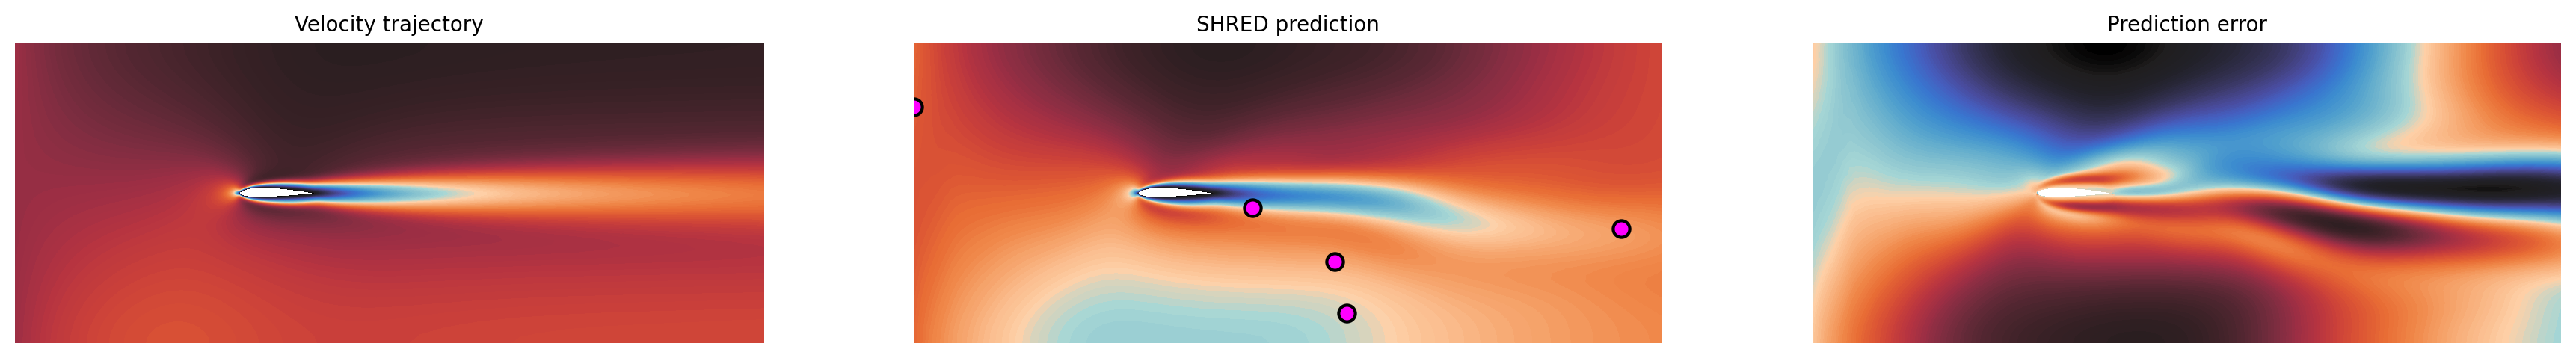

In [194]:
# FOM vs POD RECONSTRUCTION (PLOTS)

from utils.processdata import trajectories_with_sensors

whichtrajectory = 4
whichtimes = np.arange(0, 200, 10)

plotlist = [Vtest[whichtrajectory, whichtimes], Vtest_hat[whichtrajectory, whichtimes], Vtest[whichtrajectory, whichtimes] - Vtest_hat.numpy()[whichtrajectory, whichtimes]]
params_geo = MUtest[whichtrajectory, 0, 2:]

plotlist = [Vtest[whichtrajectory, whichtimes], Vtest_hat[whichtrajectory, whichtimes], Vtest[whichtrajectory, whichtimes] - Vtest_hat.numpy()[whichtrajectory, whichtimes]]


# redefine plot_v on new triang
_, triang = update_coords_and_triang(params_geo)
def plot_v(v, triang = triang):
    plt.tricontourf(triang, v, cmap = cmap, levels = 200)
    plt.gca().set_aspect("equal")
    add_zoom(zoom = 1.3)

vmin = min(np.abs(plotlist[i]).min() for i in range(len(plotlist)))
vmax = max(np.abs(plotlist[i]).max() for i in range(len(plotlist)))

trajectories_with_sensors(plotlist, plot_v, indices[idx_test][whichtrajectory], sensors_coords_test[whichtrajectory], titles = ("Velocity trajectory", "SHRED prediction", "Prediction error"), figsize = (10, 5), vertical = False, save = True)
# trajectories_with_sensors(plotlist, plot_v, idx_sensors, sensors_coords_test[:4][whichtrajectory].detach().cpu().numpy(), titles = ("Velocity trajectory", "SHRED prediction", "Prediction error"), figsize = (10, 5), vertical = False, save = True)

In [ ]:
test_hist.shape

torch.Size([2010, 5, 50])

In [ ]:
sensor_coords_exp_test.shape

torch.Size([2010, 100, 5, 2])

In [ ]:
# # # Trying test trajectories on random sensors locations
# # indices = np.stack([
# #     np.random.choice(nvelocity, nsensors, replace=False)
# #     for _ in range(ntest)
# # ], axis=0)  
# sensors_idx_test = np.stack([
#     np.random.choice(nvelocity, nsensors, replace=False)
#     for _ in range(ntest)
# ], axis=0)         # (ntrain,5)
# sensors_idx_test = sensors_idx_test[:, None, :]      # (ntest,1,5)
# sensors_data_test = torch.from_numpy(
#     Vxtest[traj_idx_test, time_idx, sensors_idx_test]
# ).float()   # → (ntest,201,5)
# test_hist = Padding(sensors_data_test, lag).transpose(1,2).to(device).contiguous() # (N_samples, lag, nsensors)
# sensor_coords_exp_test = torch.from_numpy(np.repeat(XY[np.arange(ntrajectories)[:, None], sensors_idx_test], repeats=ntimes, axis=0)).to(torch.float) #.to(device)
# field_coords_exp_test = torch.from_numpy(np.repeat(XY[idx_test], repeats=ntimes, axis=0)).to(torch.float) #.to(device)
# Vtest_POD = model(test_hist.to(device), sensor_coords_exp_test.to(device))[:, :-1]
# Vxtest_hat = torch.from_numpy(scalerVx.inverse_transform(Vtest_POD.detach().cpu().numpy()[:,:kvelocity//2])).to(torch.float32) @ Wx
# Vytest_hat = torch.from_numpy(scalerVy.inverse_transform(Vtest_POD.detach().cpu().numpy()[:,kvelocity//2:])).to(torch.float32) @ Wy
# Vtest_hat = torch.sqrt(Vxtest_hat.view(ntest, ntimes, nvelocity)**2 + Vytest_hat.view(ntest, ntimes, nvelocity)**2)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10050x200 and 2x64)

### Training sensors

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Vxtrain_POD = torch.from_numpy(Vxtrain_POD).to(device)
# Vytrain_POD = torch.from_numpy(Vytrain_POD).to(device)
# MUtrain = torch.from_numpy(MUtrain).to(device)
# # sensors_coords_new = torch.from_numpy(sensors_coords_new).to(device)
# XY = torch.from_numpy(XY).to(device)
# Vxtrain = torch.from_numpy(Vxtrain).to(device)
# Vxvalid = torch.from_numpy(Vxvalid).to(device)
# Vxtest = torch.from_numpy(Vxtest).to(device)

In [ ]:
# Vxtrain_POD = Vxtrain_POD.to(device)
# Vytrain_POD = Vytrain_POD.to(device)
# MUtrain = MUtrain.to(device)
# # sensors_coords_new = torch.from_numpy(sensors_coords_new).to(device)
# XY = XY.to(device)
# Vxtrain = Vxtrain.to(device)
# Vxvalid = Vxvalid.to(device)
# Vxtest = Vxtest.to(device)

In [ ]:
import utils.models
import utils.processdata

In [ ]:
import importlib
importlib.reload(utils.models)
importlib.reload(utils.processdata)

<module 'utils.processdata' from '/content/drive/MyDrive/SHRED-ROM/utils/processdata.py'>

In [ ]:
from utils.models import SHRED, SHREDTransformer, SHREDConcat, SHREDPerceiverSpatial
from utils.processdata import Padding, TimeSeriesDataset

In [ ]:
d = 2 # 2D

In [ ]:
# Le posizioni dei sensori sono variabili trainabili
sensors_coords = torch.rand(nsensors, d, device=device, requires_grad=True)
sensors_coords.data.mul_(torch.tensor([L, H], device=device, dtype=torch.float32))

# Inizializza il modello SHRED (o SHREDTransformer)
# Nel tuo caso il modello in input prende la time series dei sensori: shape (ntraj, ntimes, nsensors)
# e produce un output (ad es., dimensione kvelocity+1)

model = SHRED(input_size=nsensors * (d+1), output_size=kvelocity + 1, hidden_size=64, hidden_layers=2,
              decoder_sizes=[350, 400], dropout=0.1).to(device)
# model = SHREDConcat(nsensors, coord_pe_dim = 2*D, output_size=kvelocity + 1, hidden_size=64, hidden_layers=2,
#               decoder_sizes=[350, 400], dropout=0.1).to(device)
# model = SHREDPerceiverSpatial(nsensors, coord_dim = 2 * D, d_model = 64, output_size=kvelocity + 1, hidden_size=64, hidden_layers=2,
#               decoder_sizes=[350, 400], dropout=0.1).to(device)


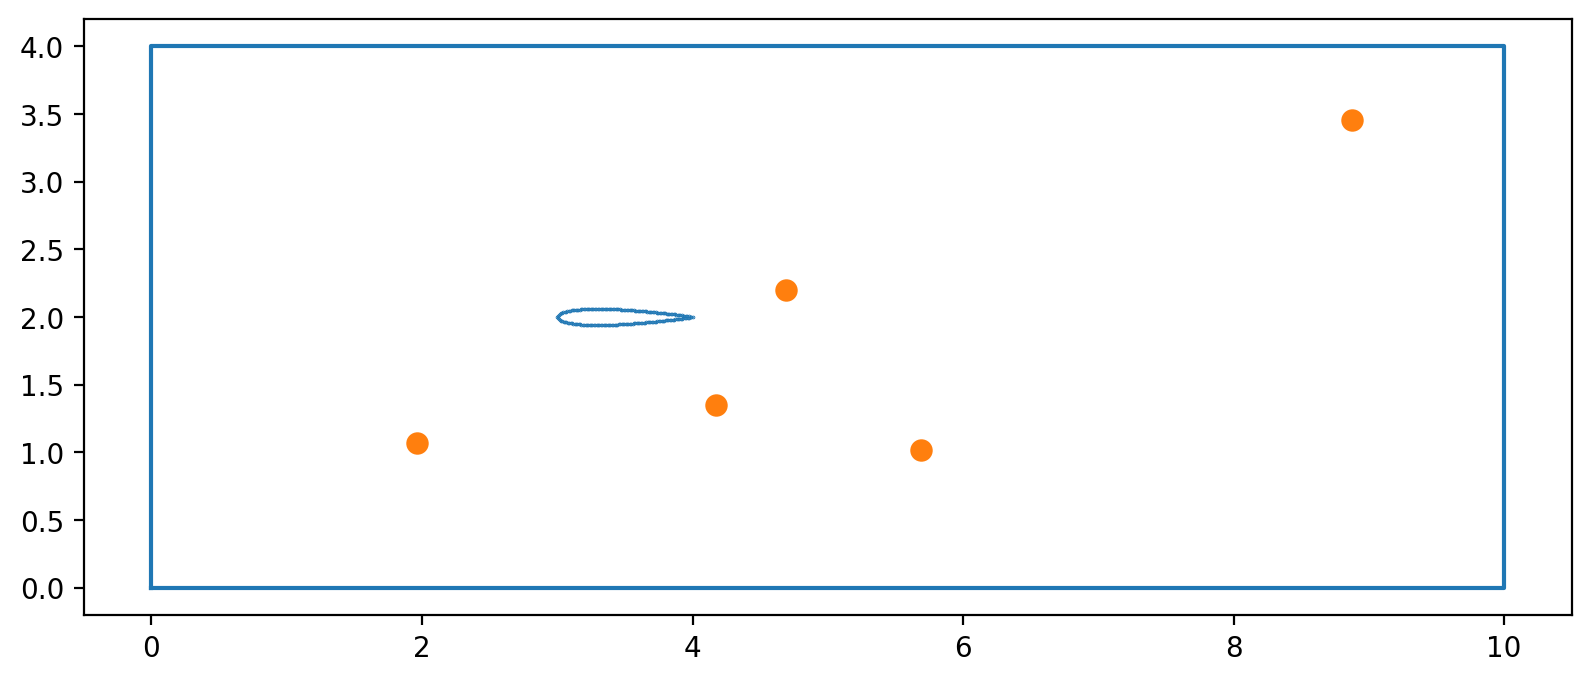

In [ ]:
plt.figure()
scatter_array(naca0012_airfoil_coords, s = 0.1)
scatter_array(sensors_coords.detach().cpu().numpy(), s = 50)
plt.plot([0, L, L, 0, 0], [0, 0, H, H, 0])
add_zoom()
plt.show()

In [ ]:
# sensor_encodings = fourier_encode(sensors_coords, B).clone().detach().to(device).requires_grad_(True)

In [ ]:
import torch
from torch.utils.data import DataLoader
from copy import deepcopy
from IPython.display import clear_output as clc
from utils.processdata import mse, mre, num2p

import torch.nn.functional as F
from utils.processdata import TimeSeriesDataset, Padding

In [ ]:
sensor_interpolator = SensorDataInterpolator(B.to(device)).to(device)  # o device appropriato


In [ ]:
lag = 50
# optim_cls=torch.optim.Adam
lr_shred=1e-3
lr_sensors=0.05
batch_size = ntimes * 2 # deve essere multiplo o divisore di ntimes
batch_size = 67
epochs = 2000
print_every_epochs = 5
update_sensors_every_steps = 20
scatter_sensors_every_steps = epochs

loss_fun = mse
loss_output = mre
formatter = num2p

train_error_list = []

In [ ]:
# Preinizializza l'ottimizzatore con i parametri del modello e anche sensors_coords
# Definisci due ottimizzatori:
optimizer_model = torch.optim.Adam(model.parameters(), lr=lr_shred)           # per il modello SHRED
optimizer_sensors = torch.optim.Adam([sensors_coords], lr=lr_sensors)         # per le coordinate dei sensori

In [ ]:
node_encodings_train = fourier_encode(XY[idx_train].view(-1, XY.shape[-1]), B).view(len(idx_train), nvelocity, -1).to(device)
node_encodings_valid = fourier_encode(XY[idx_valid].view(-1, XY.shape[-1]), B).view(len(idx_valid), nvelocity, -1).to(device)
node_encodings_test = fourier_encode(XY[idx_test].view(-1, XY.shape[-1]), B).view(len(idx_test), nvelocity, -1).to(device)

In [ ]:
train_data_out = Padding(torch.cat((Vxtrain_POD, Vytrain_POD, MUtrain[:,:,0].unsqueeze(2)), 2), 1).squeeze(1).to(device)

In [ ]:
sensors_data_train = sensor_interpolator(sensors_coords, Vxtrain, node_encodings_train)  # shape (ntraj, ntimes, nsensors)
sensors_data_valid = sensor_interpolator(sensors_coords, Vxvalid, node_encodings_valid)  # shape (ntraj, ntimes, nsensors)
sensors_data_test = sensor_interpolator(sensors_coords, Vxtest, node_encodings_test)  # shape (ntraj, ntimes, nsensors)

In [ ]:
train_dataset = TimeSeriesDataset(Padding(sensors_data_train, lag).to(device), train_data_out)
test_data_in = Padding(sensors_data_test, lag).to(device)

In [ ]:
Y_loader = DataLoader(train_data_out, shuffle=False, batch_size=batch_size)

In [ ]:
sensors_history = [sensors_coords.detach().cpu().numpy()]

In [ ]:
# sensors_coords_train = np.tile(XY[idx_train][:, idx_sensors], reps = (ntimes, 1, 1))
# sensors_coords_train = torch.from_numpy(sensors_coords_train).to(torch.float32).to(device)

# sensors_coords_valid = np.tile(XY[idx_valid][:, idx_sensors], reps = (ntimes, 1, 1))
# sensors_coords_valid = torch.from_numpy(sensors_coords_valid).to(torch.float32).to(device)

In [ ]:
# dataset = list(zip(sensors_coords_train, train_data_in, train_data_out))

In [ ]:
coords = sensors_coords.unsqueeze(0).unsqueeze(0)
coords_exp = coords.expand(len(idx_train) * ntimes, lag, nsensors, d)
train_data = torch.cat([coords_exp, train_dataset.X.unsqueeze(-1)], dim=-1)
train_data = train_data.view(len(idx_train) * ntimes, lag,
                      nsensors * (d + 1))

In [ ]:
train_data.shape

torch.Size([12864, 50, 15])

In [ ]:
X_batch.shape

torch.Size([67, 50, 15])

In [ ]:
# Inizializza la cache per memorizzare i batch calcolati
batch_cache = {}

global_step = 0
for epoch in range(1, epochs + 1):
    # print(f"epoch {epoch}")
    for batch_idx, Y_batch in enumerate(Y_loader):
        model.train()

        # # Calcola l'indice e la finestra temporale per il batch corrente (backup)
        # traj_idx = batch_idx * batch_size // ntimes
        # start_time = (batch_idx % (ntimes // batch_size)) * batch_size
        # end_time = start_time + batch_size

        # Calcola l'indice e la finestra temporale per il batch corrente
        traj_idx = [batch_idx * batch_size // ntimes] if batch_size < ntimes else np.arange(batch_idx * batch_size // ntimes, (batch_idx + 1) * batch_size // ntimes).tolist()
        start_time = (batch_idx % (ntimes // batch_size) if (ntimes // batch_size != 0) else 0) * batch_size
        end_time = start_time + batch_size

        # Definisci una chiave univoca per questo batch
        key = (traj_idx[-1], start_time, end_time)
        # print(key)

        if global_step % update_sensors_every_steps == 0 or key not in batch_cache:
            # print(f"Epoch {epoch}: interpolating...")
            sensors_coords = torch.rand(nsensors, d, device=device, requires_grad=False)
            sensors_coords.data.mul_(torch.tensor([L, H], device=device, dtype=torch.float32))
            sensor_data = sensor_interpolator(
                sensors_coords,
                Vxtrain[traj_idx][:, start_time:end_time],
                node_encodings_train[traj_idx]
            )
            sensor_encodings = fourier_encode(sensors_coords, B).detach()
            # print(sensor_data.shape)
            X_batch = Padding(sensor_data, lag).to(device)
            # print(X_batch.shape)
            batch_cache[key] = X_batch  # salva X_batch nel cache con grafo attivo
        else:
            # Usa il valore in cache ma "detach" per non propagare i gradienti
            X_batch = batch_cache[key].detach()
            # X_batch = gate_gradient(batch_cache[key].clone(), 0.0)

        # Concatenazione con coordinate sensori
        coords = sensors_coords.unsqueeze(0).unsqueeze(0)
        coords_exp = coords.expand(batch_size, lag, nsensors, d)
        X_batch = torch.cat([coords_exp, X_batch.unsqueeze(-1)], dim=-1)
        X_batch = X_batch.view(batch_size,
                              lag,
                              nsensors * (d + 1))

        # Procedi con il resto del forward e backward
        optimizer_model.zero_grad()
        # optimizer_sensors.zero_grad()
        outputs = model(X_batch)
        loss = loss_fun(outputs, Y_batch)
        loss.backward()
        optimizer_model.step()

    # if global_step % update_sensors_every_steps == 0:
    #     optimizer_sensors.step()
    #     # Applica il reflection in-place sui sensori
    #     # sensors_coords.data = reflect_coords(sensors_coords.data, L, H)
    #     sensors_coords.data = reflect_with_grad_flip(sensors_coords.data, L, H)

    global_step += 1

    if global_step % update_sensors_every_steps == 0:
        # sensors_history.append(fourier_decode(sensor_encodings.cpu()).detach().cpu().numpy())
        sensors_history.append(sensors_coords.detach().cpu().numpy())
    # Logging e validazione
    if epoch % print_every_epochs == 0:
        model.eval()
        with torch.no_grad():
            train_error = loss_output(train_dataset.Y, model(train_data))
            train_error_list.append(train_error)
        print(f"Epoch {epoch}: Training loss = {formatter(train_error_list[-1])}")

    if epoch % scatter_sensors_every_steps == 0:
        print(sensors_coords.detach().cpu().numpy())

Epoch 5: Training loss = 21.21%
Epoch 10: Training loss = 20.92%
Epoch 15: Training loss = 20.86%
Epoch 20: Training loss = 20.77%
Epoch 25: Training loss = 20.71%
Epoch 30: Training loss = 20.62%
Epoch 35: Training loss = 20.53%
Epoch 40: Training loss = 20.40%
Epoch 45: Training loss = 20.35%
Epoch 50: Training loss = 20.34%
Epoch 55: Training loss = 20.35%
Epoch 60: Training loss = 20.36%
Epoch 65: Training loss = 20.27%
Epoch 70: Training loss = 20.30%
Epoch 75: Training loss = 20.25%
Epoch 80: Training loss = 20.25%
Epoch 85: Training loss = 20.59%
Epoch 90: Training loss = 20.67%
Epoch 95: Training loss = 20.62%


KeyboardInterrupt: 

In [ ]:
model.mix

In [ ]:
colors = [
    'red',
    'blue',
    'green',
    'orange',
    'purple',
    'cyan',
    'magenta',
    'yellow',
    'brown',
    'gray'
]

In [ ]:
plt.figure()

# Airfoil senza label
scatter_array(naca0012_airfoil_coords, s=0.1, label='_nolegend_')

# Dominio senza label
plt.plot([0, L, L, 0, 0], [0, 0, H, H, 0], label='_nolegend_')

# Numero di sensori
num_sensors = len(sensors_history[0])

for i in range(num_sensors):
    traj = np.array([step[i] for step in sensors_history])

    # Linea della traiettoria
    plt.plot(traj[:, 0], traj[:, 1], color=colors[i], label=f'Sensor {i+1}', linewidth = 1)

    # Marker inizio con colore della linea
    plt.scatter(traj[0, 0], traj[0, 1], color=colors[i], edgecolors='k', marker='o', s=100, label='_nolegend_')

    # Marker fine con colore della linea
    plt.scatter(traj[-1, 0], traj[-1, 1], color=colors[i], edgecolors='k', marker='X', s=100, label='_nolegend_')

# Aggiungi marker "Start" e "End" alla legenda con solo bordo nero
plt.scatter([], [], facecolors='none', edgecolors='k', marker='o', s=100, label='Start')
plt.scatter([], [], facecolors='none', edgecolors='k', marker='X', s=100, label='End')

plt.title("Traiettorie dei sensori")
plt.xlabel("X")
plt.ylabel("Y")
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
# plt.tight_layout()
add_zoom()
plt.show()


### Positional encoding 2

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
traj_id = [20]

In [ ]:
train_trajectories = len(idx_train)
train_trajectories

80

In [ ]:
!pip install pydoe

In [ ]:
from pyDOE import lhs

In [ ]:
nsensors = 2000

In [ ]:
# sensors_coords_new = np.concatenate((np.random.rand(nsensors, 1) * (xmax - xmin) + xmin, np.random.rand(nsensors, 1) * (ymax - ymin) + ymin), 1, dtype = np.float32)
sensors_coords_new = lhs(2, nsensors) * [L, H]
sensors_coords_new = torch.from_numpy(sensors_coords_new).to(torch.float32)
# XY = torch.from_numpy(XY)
# Vxtrain = torch.from_numpy(Vxtrain)

In [ ]:
import torch
import torch.nn.functional as F

# --------------------------------------------------
# 1. Definizione della funzione di Fourier Positional Encoding
# --------------------------------------------------
def fourier_encode(x, B):
    """
    Applica il positional encoding Fourier alle coordinate.

    Parametri:
      - x: tensor di shape (n, d) (ad esempio, coordinate spaziali)
      - B: tensor di shape (d, D) contenente le frequenze.

    Restituisce:
      - encoding: tensor di shape (n, 2*D) ottenuto concatenando sin(xB) e cos(xB).
    """
    # Proiezione: x @ B produce un tensore di shape (n, D)
    x_proj = 2 * torch.pi * x @ B
    return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

# --------------------------------------------------
# 2. Setup dei parametri e degli input
# --------------------------------------------------
d = 2   # dimensione originale delle coordinate (x, y)
D = 16  # dimensione scelta per la proiezione (puoi variare questo parametro)

# Matrice di frequenze per il Fourier encoding (può essere fissata oppure resa learnable)
B = torch.randn(d, D).to(device)

# --------------------------------------------------
# 3. Calcolo degli encoding Fourier per i nodi e per i sensori
# --------------------------------------------------
# Calcolo dell'encoding per i sensori: shape (nsensors, 2*D)
sensor_encodings = fourier_encode(sensors_coords_new, B)  # comune a tutte le traiettorie

# Calcolo dell'encoding per i nodi per tutte le traiettorie.
# Risultato atteso: (ntraj, nvelocity, 2*D)
# Possiamo calcolarlo in modo vettorizzato:

node_encodings_train = fourier_encode(XY[idx_train][traj_id].view(-1, d), B)
# node_encodings_train = node_encodings_train.view(len(idx_train), nvelocity, 2 * D)
node_encodings_train = node_encodings_train.view(len([traj_id]), nvelocity, 2 * D)

# node_encodings_valid = fourier_encode(XY[idx_valid].view(-1, d), B)
# node_encodings_valid = node_encodings_valid.view(len(idx_valid), nvelocity, 2 * D)

# node_encodings_test = fourier_encode(XY[idx_test].view(-1, d), B)
# node_encodings_test = node_encodings_test.view(len(idx_test), nvelocity, 2 * D)

In [ ]:
# --------------------------------------------------
# 4. Calcolo dei pesi di similarità e interpolazione
# --------------------------------------------------
# Per ogni traiettoria, calcoliamo la similarità fra i sensori e i nodi.
# Usiamo broadcasting per ottenere in una sola operazione:
#
#   sensor_encodings: (nsensors, 2*D)
#   node_encodings: (ntraj, nvelocity, 2*D)
#
# Vogliamo ottenere similarity: (ntraj, nsensors, nvelocity)
# facendo, per ogni traiettoria i e per ogni sensore j,
#   similarity[i,j] = sensor_encodings[j] · node_encodings[i].T
sensor_encodings_expanded = sensor_encodings.unsqueeze(0)  # shape: (1, nsensors, 2*D)


In [ ]:
# Trasponiamo l'encoding dei nodi per il prodotto scalare:
node_encodings_t = node_encodings_train  # shape: (ntraj, nvelocity, 2*D)
similarity = torch.matmul(sensor_encodings_expanded, node_encodings_t.transpose(1,2))
# similarity: (ntraj, nsensors, nvelocity)

# Otteniamo i pesi (softmax sul nodo-dimensione, ovvero dim=2)
weights = F.softmax(similarity, dim=2)  # shape: (ntraj, nsensors, nvelocity)

# Ora, per ogni traiettoria e per ogni timestep, eseguiamo la media pesata dei valori dei nodi.
# Vxtrain ha shape: (ntraj, ntimes, nvelocity)
# Per eseguire la moltiplicazione, trasponiamo weights in modo che abbiano shape (ntraj, nvelocity, nsensors)
weights_t = weights.transpose(1,2)  # shape: (ntraj, nvelocity, nsensors)

sensors_data_train = torch.matmul(Vxtrain[traj_id], weights_t)

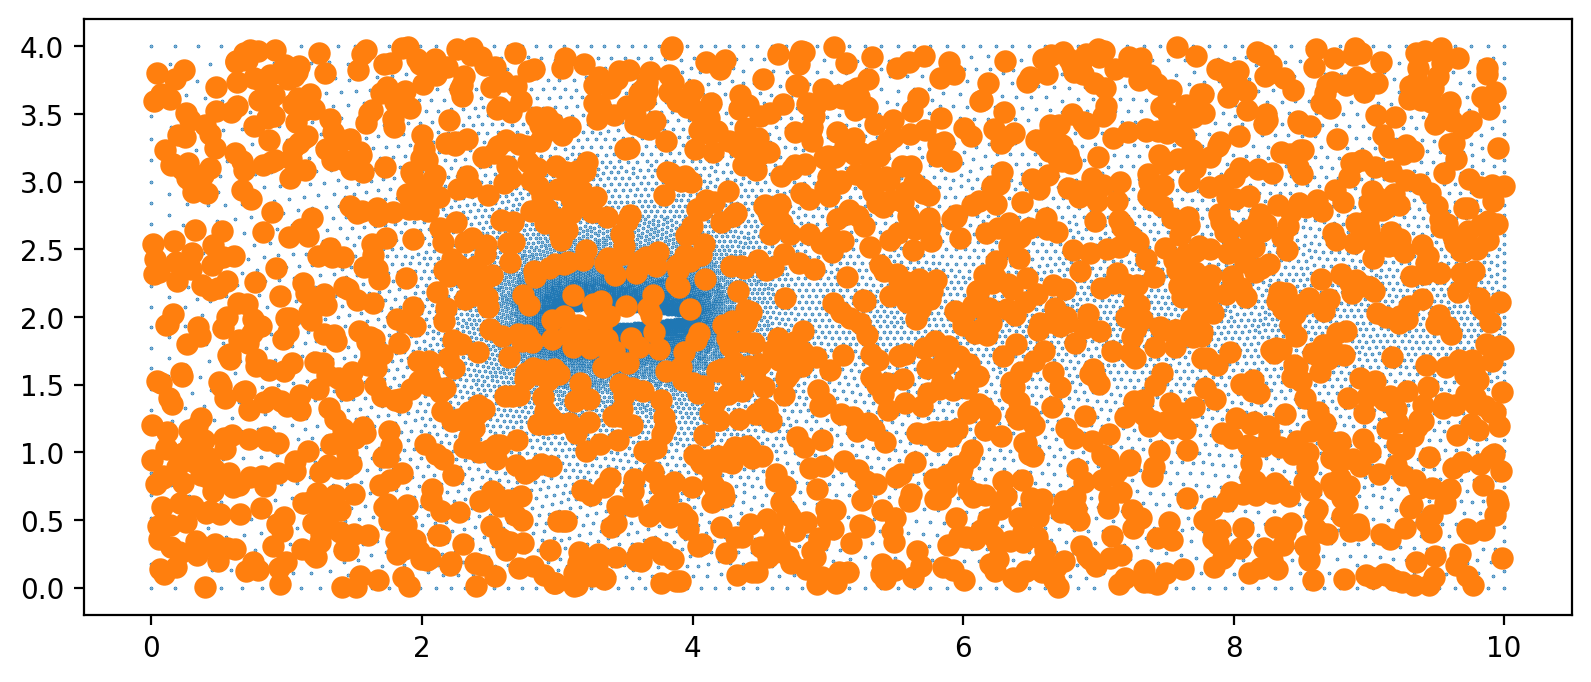

In [ ]:
scatter_array(naca0012_coords, s = 0.1)
scatter_array(sensors_coords_new, s = 50)
add_zoom()

In [ ]:
# TRAJECTORY WITH SENSORS (PLOT)
import matplotlib as mpl

def trajectory_with_sensors(vt, params_geo, sensors_coordinates, sensors_values, title = None):
    """
    Velocity trajectory with sensors
    Input: velocity trajectory with dimension (ntimes, nvelocity), geometric parameters and and the selected sensor indices
    """
    # redefine plot_v on new triang
    coords, triang = update_coords_and_triang(params_geo)
    norm = mpl.colors.Normalize(vmin = vt.min().item(), vmax = vt.max().item())
    def plot_v(v, triang = triang):
        plt.tricontourf(triang, v, cmap = cmap, levels = 200, norm = norm)
        plt.gca().set_aspect("equal")
        add_zoom(zoom = 1.3)

    # sensors_coordinates = coords[idx_sensors, :2]
    nsensors = sensors_coordinates.shape[0]

    for i in range(vt.shape[0]):
        plt.figure(figsize=(10,10))
        # plot_v(vt[i])
        for k in np.arange(nsensors):
            plt.scatter(sensors_coordinates[k, 0], sensors_coordinates[k, 1], c = sensors_values[i, k],
                        facecolors='none',   # interno trasparente
                        edgecolors='white',
                        marker = 'o', norm = norm, s = 100, cmap = cmap) # , mec = 'black', ms = 8, mew = 1.5)
        plt.xlim((-0.1,10.1))
        plt.title(title)
        plt.axis('off')
        display(plt.gcf())
        plt.close()
        clc(wait=True)

# whichtrajectory = 3
whichtrajectory = 0
whichtimes = np.arange(0, 200, 10)

trajectory_with_sensors(Vxtrain[whichtrajectory, whichtimes],
                        MUtrain[whichtrajectory, 0, 2:],
                        sensors_coordinates=sensors_coords_new,
                        sensors_values= sensors_data_train.detach().numpy()[whichtrajectory, whichtimes],
                        title = "Velocity trajectory with sensors")

### Training

In [ ]:
# EXTRACT SENSOR DATA (SKIP THIS CELL IF DATA ALREADY AVAILABLE)
idx_sensors = np.random.choice(nvelocity, size = nsensors, replace = False)

sensors_data_train = Vxtrain[:,:,idx_sensors]
sensors_data_valid = Vxvalid[:,:,idx_sensors]
sensors_data_test = Vxtest[:,:,idx_sensors]

In [ ]:
# # sensors_data_train = torch.from_numpy(sensors_data_train)
# # sensors_data_valid = torch.from_numpy(sensors_data_valid)
# # sensors_data_test = torch.from_numpy(sensors_data_test)

# # Vxtrain_POD = torch.from_numpy(Vxtrain_POD)
# Vxvalid_POD = torch.from_numpy(Vxvalid_POD)
# Vxtest_POD = torch.from_numpy(Vxtest_POD)

# # Vytrain_POD = torch.from_numpy(Vytrain_POD)
# Vyvalid_POD = torch.from_numpy(Vyvalid_POD)
# Vytest_POD = torch.from_numpy(Vytest_POD)

# # MUtrain = torch.from_numpy(MUtrain)
# MUvalid = torch.from_numpy(MUvalid)
# MUtest = torch.from_numpy(MUtest)


In [ ]:
sensors_data_train = torch.from_numpy(sensors_data_train)
sensors_data_valid = torch.from_numpy(sensors_data_valid)
sensors_data_test = torch.from_numpy(sensors_data_test)

Vxtrain_POD = torch.from_numpy(Vxtrain_POD)
Vxvalid_POD = torch.from_numpy(Vxvalid_POD)
Vxtest_POD = torch.from_numpy(Vxtest_POD)

Vytrain_POD = torch.from_numpy(Vytrain_POD)
Vyvalid_POD = torch.from_numpy(Vyvalid_POD)
Vytest_POD = torch.from_numpy(Vytest_POD)

MUtrain = torch.from_numpy(MUtrain)
MUvalid = torch.from_numpy(MUvalid)
MUtest = torch.from_numpy(MUtest)


In [ ]:
# BUILD TRAIN, VALIDATION AND TEST DATASETS WITH PADDING

from utils.processdata import Padding, TimeSeriesDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lag = 50

train_data_in = Padding(sensors_data_train, lag).to(device)
valid_data_in = Padding(sensors_data_valid, lag).to(device)
test_data_in = Padding(sensors_data_test, lag).to(device)


In [ ]:
train_data_out = Padding(torch.cat((Vxtrain_POD, Vytrain_POD, MUtrain[:,:,0].unsqueeze(2)), 2), 1).squeeze(1).to(device)
valid_data_out = Padding(torch.cat((Vxvalid_POD, Vyvalid_POD, MUvalid[:,:,0].unsqueeze(2)), 2), 1).squeeze(1).to(device)
test_data_out = Padding(torch.cat((Vxtest_POD, Vytest_POD, MUtest[:,:,0].unsqueeze(2)), 2), 1).squeeze(1).to(device)

train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

In [ ]:
import torch
from torch.utils.data import DataLoader
from copy import deepcopy
from IPython.display import clear_output as clc
from utils.processdata import mse, mre, num2p

import torch.nn.functional as F
from utils.processdata import TimeSeriesDataset, Padding

In [ ]:
import torch
from torch.utils.data import DataLoader
from copy import deepcopy

def fit_with_memory_monitoring(model, train_dataset, valid_dataset, batch_size=64, epochs=1000,
                               optim=torch.optim.Adam, lr=1e-3, loss_fun=mse, loss_output=mre,
                               formatter=num2p, verbose=True, patience=100, monitor_interval=10, device="cuda"):
    train_loader = DataLoader(train_dataset, shuffle=True, batch_size=batch_size)
    optimizer = optim(model.parameters(), lr=lr)

    train_error_list = []
    valid_error_list = []
    patience_counter = 0
    best_params = deepcopy(model.state_dict())
    global_step = 0

    for epoch in range(1, epochs + 1):

        for k, data in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            outputs = model(data[0].to(device))
            loss = loss_fun(outputs, data[1].to(device))
            loss.backward()
            optimizer.step()
            global_step += 1

        model.eval()
        with torch.no_grad():
            train_error = loss_output(train_dataset.Y.to(device), model(train_dataset.X.to(device)))
            valid_error = loss_output(valid_dataset.Y.to(device), model(valid_dataset.X.to(device)))
            train_error_list.append(train_error)
            valid_error_list.append(valid_error)

        if verbose:
            print("Epoch {:d}: Training loss = {} \t Validation loss = {}".format(
                epoch, formatter(train_error_list[-1]), formatter(valid_error_list[-1])
            ))

            # Monitoraggio della memoria ogni 'monitor_interval' epoche
            if epoch % monitor_interval == 0:
                mem_alloc = torch.cuda.memory_allocated(device) / 1024**2
                mem_reserved = torch.cuda.memory_reserved(device) / 1024**2
                print("GPU memory allocated: {:.2f} MB, reserved: {:.2f} MB".format(mem_alloc, mem_reserved))
                # Puoi anche stampare un report più completo se vuoi:
                # print(torch.cuda.memory_summary(device=device))

        if valid_error == torch.min(torch.tensor(valid_error_list)):
            patience_counter = 0
            best_params = deepcopy(model.state_dict())
        else:
            patience_counter += 1

        if patience_counter == patience:
            model.load_state_dict(best_params)
            train_error = loss_output(train_dataset.Y.to(device), model(train_dataset.X.to(device)))
            valid_error = loss_output(valid_dataset.Y.to(device), model(valid_dataset.X.to(device)))
            if verbose:
                print("Training done: Training loss = {} \t Validation loss = {}".format(
                    formatter(train_error), formatter(valid_error)
                ))
            return (torch.tensor(train_error_list).detach().cpu().numpy(),
                    torch.tensor(valid_error_list).detach().cpu().numpy())

    model.load_state_dict(best_params)
    train_error = loss_output(train_dataset.Y.to(device), model(train_dataset.X.to(device)))
    valid_error = loss_output(valid_dataset.Y.to(device), model(valid_dataset.X.to(device)))
    if verbose:
        print("Training done: Training loss = {} \t Validation loss = {}".format(
            formatter(train_error), formatter(valid_error)
        ))
    return (torch.tensor(train_error_list).detach().cpu().numpy(),
            torch.tensor(valid_error_list).detach().cpu().numpy())


In [ ]:
mem_alloc = torch.cuda.memory_allocated(device) / 1024**2
mem_reserved = torch.cuda.memory_reserved(device) / 1024**2
print("GPU memory allocated: {:.2f} MB, reserved: {:.2f} MB".format(mem_alloc, mem_reserved))

GPU memory allocated: 47.47 MB, reserved: 64.00 MB


In [ ]:
import importlib
import utils.models
import utils.processdata
importlib.reload(utils.models)
importlib.reload(utils.processdata)
import utils.models
import utils.processdata
from utils.models import SHRED, SHREDTransformer, fit_sensors_coords
from utils.processdata import Padding, TimeSeriesDataset

In [ ]:
sensors_coords_train = np.tile(XY[idx_train][:, idx_sensors], reps = (ntimes, 1, 1))
sensors_coords_train = torch.from_numpy(sensors_coords_train).to(torch.float32).to(device)

sensors_coords_valid = np.tile(XY[idx_valid][:, idx_sensors], reps = (ntimes, 1, 1))
sensors_coords_valid = torch.from_numpy(sensors_coords_valid).to(torch.float32).to(device)

In [ ]:
dataset = list(zip(sensors_coords_train, train_data_in, train_data_out))

In [ ]:
# SHRED TRAINING (SKIP THIS CELL IF SHRED ALREADY AVAILABLE)

from utils.models import SHRED, SHREDTransformer, fit

shred = SHRED(nsensors, kvelocity + 1, hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.1).to(device)
train_errors, valid_errors = fit_sensors_coords(shred, train_dataset, valid_dataset, sensors_coords_train, sensors_coords_valid, batch_size = 64, epochs = 1000, lr = 1e-3, verbose = True, patience = 100) # , device = device)

Epoch 1: Training loss = 15.34% 	 Validation loss = 15.84%
Epoch 2: Training loss = 14.60% 	 Validation loss = 15.16%
Epoch 3: Training loss = 13.81% 	 Validation loss = 14.32%
Epoch 4: Training loss = 13.17% 	 Validation loss = 13.79%
Epoch 5: Training loss = 12.59% 	 Validation loss = 13.50%
Epoch 6: Training loss = 12.32% 	 Validation loss = 13.33%
Epoch 7: Training loss = 11.94% 	 Validation loss = 13.09%
Epoch 8: Training loss = 11.44% 	 Validation loss = 12.65%
Epoch 9: Training loss = 10.88% 	 Validation loss = 12.49%
Epoch 10: Training loss = 10.43% 	 Validation loss = 11.89%
Epoch 11: Training loss = 10.15% 	 Validation loss = 11.73%
Epoch 12: Training loss = 9.79% 	 Validation loss = 11.45%
Epoch 13: Training loss = 9.52% 	 Validation loss = 11.27%
Epoch 14: Training loss = 9.24% 	 Validation loss = 11.06%
Epoch 15: Training loss = 8.97% 	 Validation loss = 11.01%
Epoch 16: Training loss = 8.71% 	 Validation loss = 10.66%
Epoch 17: Training loss = 8.45% 	 Validation loss = 10

In [ ]:
# # SHRED LOADING

# from utils.models import SHRED

# shred = SHRED(nsensors, kvelocity + 1, hidden_size = 64, hidden_layers = 2, decoder_sizes = [350, 400], dropout = 0.1).to(device)
# shred.load_state_dict(torch.load('FlowAroundObstacle_shred_velocity_paramestimation.pt', weights_only = True, map_location = torch.device(device)));

In [ ]:
Wx = torch.from_numpy(Wx)
Wy = torch.from_numpy(Wy)

In [ ]:
sensors_coords_test = np.tile(XY[idx_test][:, idx_sensors].cpu().numpy(), reps = (ntimes, 1, 1))
sensors_coords_test = torch.from_numpy(sensors_coords_test).to(torch.float32).to(device)

In [ ]:
# SHRED ERRORS ON TEST DATA

shred.freeze()

test_dataset_out_hat = shred(test_data_in, sensors_coords_test).cpu()

alpha_in_test_hat = test_dataset_out_hat[:,-1].reshape(ntest, ntimes)

Vtest_POD_hat = test_dataset_out_hat[:,:-1]
Vxtest_hat = torch.from_numpy(scalerVx.inverse_transform(Vtest_POD_hat.detach()[:,:kvelocity//2])).to(torch.float32) @ Wx
Vytest_hat = torch.from_numpy(scalerVy.inverse_transform(Vtest_POD_hat.detach()[:,kvelocity//2:])).to(torch.float32) @ Wy

Vtest_hat = torch.zeros(ntest, ntimes, nvelocity)
# Vtest_hat[:, :, 0 : nvelocity : 2] = Vxtest_hat.reshape(ntest, ntimes, nvelocity//2)
# Vtest_hat[:, :, 1 : nvelocity : 2] = Vytest_hat.reshape(ntest, ntimes, nvelocity//2)
Vtest_hat = torch.sqrt(Vxtest_hat.reshape(ntest, ntimes, nvelocity)**2 + Vytest_hat.reshape(ntest, ntimes, nvelocity)**2)

# print("Mean relative SHRED prediction error on V: %s" % num2p(mre(Vtest, Vtest_hat)))
# print("Mean absolute SHRED prediction error on the angle of attack: %s" % round(mae(MUtest[:,:,0], alpha_in_test_hat).item(), 3))

In [ ]:
# train_dataset_out_hat = model(Padding(sensors_data_train, lag).to(device)).cpu()

In [ ]:
# alpha_in_train_hat = train_dataset_out_hat[:,-1].reshape(ntrain, ntimes)

# Vtrain_POD_hat = train_dataset_out_hat[:,:-1]
# Vxtrain_hat = torch.from_numpy(scalerVx.inverse_transform(Vtrain_POD_hat[:,:kvelocity//2])) @ Wx
# Vytrain_hat = torch.from_numpy(scalerVy.inverse_transform(Vtrain_POD_hat[:,kvelocity//2:])) @ Wy

# Vtrain_hat = torch.zeros(ntrain, ntimes, nvelocity)
# # Vtest_hat[:, :, 0 : nvelocity : 2] = Vxtest_hat.reshape(ntest, ntimes, nvelocity//2)
# # Vtest_hat[:, :, 1 : nvelocity : 2] = Vytest_hat.reshape(ntest, ntimes, nvelocity//2)
# Vtrain_hat = torch.sqrt(Vxtrain_hat.reshape(ntest, ntimes, nvelocity)**2 + Vytrain_hat.reshape(ntest, ntimes, nvelocity)**2)

In [ ]:
# Vxtest_hat = Vxtest_hat.reshape(ntest, ntimes, nvelocity)
# Vytest_hat = Vytest_hat.reshape(ntest, ntimes, nvelocity)

In [ ]:
# FOM vs POD RECONSTRUCTION (PLOTS)

from utils.processdata import trajectories_with_sensors

whichtrajectory = 2
whichtimes = np.arange(0, 200, 10)

plotlist = [Vtest[whichtrajectory, whichtimes], Vtest_hat[whichtrajectory, whichtimes], Vtest[whichtrajectory, whichtimes] - Vtest_hat.numpy()[whichtrajectory, whichtimes]]
params_geo = MUtest[whichtrajectory, 0, 2:]

plotlist = [Vtest[whichtrajectory, whichtimes], Vtest_hat[whichtrajectory, whichtimes], Vtest[whichtrajectory, whichtimes] - Vtest_hat.numpy()[whichtrajectory, whichtimes]]


# redefine plot_v on new triang
_, triang = update_coords_and_triang(params_geo)
def plot_v(v, triang = triang):
    plt.tricontourf(triang, v, cmap = cmap, levels = 200)
    plt.gca().set_aspect("equal")
    add_zoom(zoom = 1.3)

vmin = min(np.abs(plotlist[i]).min() for i in range(len(plotlist)))
vmax = max(np.abs(plotlist[i]).max() for i in range(len(plotlist)))

trajectories_with_sensors(plotlist, plot_v, idx_sensors, sensors_coords_test[whichtrajectory].detach().cpu().numpy(), titles = ("Velocity trajectory", "SHRED prediction", "Prediction error"), figsize = (10, 5), vertical = False, save = True)

In [ ]:
# FOM vs SHRED PREDICTION (PLOTS)

def trajectories_with_sensors(vts, params_geo, idx_sensors, titles = None):
    """
    Trajectories with sensors
    Input: list of trajectories with dimension (ntimes, nstate), geometric parameters and and the selected sensor indices
    """

    # redefine plot_v on new triang
    coords, triang = update_coords_and_triang(params_geo)
    def plot_v(v, triang = triang):
        plt.tricontourf(triang, v, cmap = cmap, levels = 200)
        plt.gca().set_aspect("equal")
        add_zoom(zoom = 1.3)

    sensors_coordinates = coords[idx_sensors, :2]

    for i in range(vts[0].shape[0]):

        vmin = min(vts[j].abs().min() for j in range(len(vts)))
        vmax = max(vts[j].abs().max() for j in range(len(vts)))

        plt.figure(figsize = (10, 5))
        for j in range(len(vts)):
            plot_v(vts[j][i])
            if j < len(vts)-1:
               for k in np.arange(nsensors):
                   plt.plot(sensors_coordinates[k, 0], sensors_coordinates[k, 1], 'o', mfc = 'magenta', mec = 'black', ms = 8, mew = 1.5)
            plt.xlim((-0.1,10.1))
            plt.title(titles[j])
            plt.axis('off')

        display(plt.gcf())
        plt.close()
        clc(wait=True)

whichtrajectory = 0
whichtimes = np.arange(180, 200)

plotlist = [Vtest[whichtrajectory, whichtimes], Vtest_hat.numpy()[whichtrajectory, whichtimes], Vtest[whichtrajectory, whichtimes] - Vtest_hat.numpy()[whichtrajectory, whichtimes]]

trajectories_with_sensors(plotlist, MUtest[whichtrajectory, 0, 2:], idx_sensors, titles = ("Velocity trajectory", "SHRED prediction", "Prediction error"))

In [ ]:
type(Vtest_hat)

In [ ]:
# PARAMETER vs SHRED PREDICTION (PLOT)

times = np.arange(0, T + float(dt), float(dt))

def trajectory_parameter_estimation(MU, MU_hat, title = None):
    """
    Trajectory for parameter estimation in time
    Input: ground truth trajectory and corresponding estimate
    """

    plt.figure(figsize = (7,5))
    for i in range(1, MU.shape[0] + 1):
        plt.plot(times[:i], MU[:i], color = "black", linewidth = 2, label = r"$\alpha_{in}$")
        plt.plot(times[:i], MU_hat[:i], color = "magenta", linewidth = 2, label = r"$\hat {\alpha}_{in}$")
        plt.plot(times[i-1], MU[i-1], 'o', color = "black")
        plt.plot(times[i-1], MU_hat[i-1], 'o', color = "magenta")
        if i < MU.shape[0]:
            plt.vlines(times[i-1], -2,  2, color = "lightgray")
        plt.grid()
        plt.xlabel("Time $t$", fontsize = 15)
        plt.xticks(fontsize = 13)
        plt.yticks(fontsize = 13)
        plt.xlim((times[0]-0.5, times[-1]+0.55))
        plt.ylim((-1.2, 1.2))
        plt.legend(fontsize = 15, loc='upper left', handlelength = 1.0, shadow = True)
        plt.title(title, fontsize = 13)
        display(plt.gcf())
        plt.close()
        clc(wait=True)

whichtrajectory = 0

trajectory_parameter_estimation(MUtest[whichtrajectory,:,0], alpha_in_test_hat[whichtrajectory], title = ("Parameter estimation"))